In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings

# Configure settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 1: Load Data

Load the cleaned freight and black swan disruption data prepared in the data collection notebook.

In [20]:
# Load all processed data from data/processed/ directory
import os

def load_processed_csv(filename, parse_dates=None, index_col=None):
    """Load CSV from data/processed/ with error handling"""
    path = f'data/processed/{filename}'
    try:
        df = pd.read_csv(path, parse_dates=parse_dates, index_col=index_col)
        print(f"✓ Loaded {filename}: {len(df)} rows, {len(df.columns)} columns")
        return df
    except FileNotFoundError:
        print(f"✗ File not found: {path}")
        return None
    except Exception as e:
        print(f"✗ Error loading {path}: {str(e)}")
        return None

print("=" * 70)
print("LOADING PROCESSED DATA")
print("=" * 70)

# Load freight data (main dataset)
df_freight = load_processed_csv('freight_data.csv', parse_dates=['Date'], index_col='Date')
if df_freight is None:
    raise FileNotFoundError('Freight data is required. Run 01_data_collection.ipynb first.')

# Load oil data
df_brent_oil = load_processed_csv('collected_brent_oil_data.csv', parse_dates=['observation_date'], index_col='observation_date')
has_brent = df_brent_oil is not None

# Load geopolitical/GDELT data
df_news = load_processed_csv('geopolitical_data.csv', parse_dates=True, index_col=0)
has_news = df_news is not None

# Load new datasets
shanghai_weekly = load_processed_csv('shanghai_port_weekly.csv', parse_dates=True, index_col=0)
chokepoints_weekly = load_processed_csv('chokepoints_weekly.csv', parse_dates=True, index_col=0)
china_trade_weekly = load_processed_csv('china_monthly_trade_weekly.csv', parse_dates=True, index_col=0)

print("\n" + "=" * 70)
print("DATA LOADING COMPLETE")
print("=" * 70)

LOADING PROCESSED DATA
✓ Loaded freight_data.csv: 385 rows, 2 columns
✓ Loaded collected_brent_oil_data.csv: 399 rows, 1 columns
✓ Loaded geopolitical_data.csv: 385 rows, 21 columns
✓ Loaded shanghai_port_weekly.csv: 357 rows, 22 columns
✓ Loaded chokepoints_weekly.csv: 358 rows, 24 columns
✓ Loaded china_monthly_trade_weekly.csv: 330 rows, 24 columns

DATA LOADING COMPLETE


## Step 2: Merge Datasets and Create Target Variable

Perform inner join on date index and create the 1-week ahead price prediction target.

In [21]:
# Merge freight and disruption data and include new weekly inputs (Shanghai port, chokepoints, China trade)
# Ensure df_freight is weekly-indexed (it should be weekly on Fridays already)
if df_freight is None:
    raise FileNotFoundError('Freight data not loaded — cannot continue merging')

# Start combined dataset with freight
df_combined = df_freight.copy()
# Ensure index is timezone-naive
if df_combined.index.tz is not None:
    df_combined.index = df_combined.index.tz_localize(None)

# Join GDELT / news if available
if has_news:
    # df_news may be weekly already; align on weekly index
    news_df = df_news.copy()
    if news_df.index.tz is not None:
        news_df.index = news_df.index.tz_localize(None)
    df_combined = df_combined.join(news_df, how='left')
    print('Joined geopolitical/news features')

# Resample oil data to weekly frequency (Fridays to match freight data)
if has_brent:
    df_brent_weekly = df_brent_oil.resample('W-FRI').last()
    if df_brent_weekly.index.tz is not None:
        df_brent_weekly.index = df_brent_weekly.index.tz_localize(None)
    df_combined = df_combined.join(df_brent_weekly, how='left')
    print('Merged Brent EU oil data (resampled to weekly)')

# Join Shanghai port weekly metrics if available
if shanghai_weekly is not None:
    # The processed file uses a weekly index (week end). Ensure index is datetime and align to df_combined
    sh = shanghai_weekly.copy()
    sh.index = pd.to_datetime(sh.index)
    if sh.index.tz is not None:
        sh.index = sh.index.tz_localize(None)
    # Prefix columns to avoid collisions
    sh = sh.add_prefix('sh_')
    df_combined = df_combined.join(sh, how='left')
    print('Joined Shanghai port weekly metrics')

# Join chokepoints weekly (wide pivot) if available
if chokepoints_weekly is not None:
    ch = chokepoints_weekly.copy()
    ch.index = pd.to_datetime(ch.index)
    if ch.index.tz is not None:
        ch.index = ch.index.tz_localize(None)
    # Columns are already descriptive after pivot; prefix with choke_
    ch.columns = [f'choke_{c}' for c in ch.columns]
    df_combined = df_combined.join(ch, how='left')
    print('Joined chokepoints weekly metrics')

# Handle missing oil data with forward/backward fill
if 'Brent_Price' in df_combined.columns:
    missing_brent = df_combined['Brent_Price'].isna().sum()
    if missing_brent > 0:
        print(f"Found {missing_brent} missing Brent oil prices. Filling with forward/backward fill.")
        df_combined['Brent_Price'] = df_combined['Brent_Price'].fillna(method='ffill').fillna(method='bfill')
        print("✓ Filled missing Brent oil prices")

# ====================================================================
# FIX FOR DATA LEAKAGE: Create target BEFORE we lag features
# This ensures we don't use the same week's features to predict that week's price
# ====================================================================
print("\n" + "="*70)
print("CREATING TARGET VARIABLE (WITH LEAKAGE PREVENTION)")
print("="*70)

if 'Europe_Base_Price' in df_combined.columns:
    # Target = next week's price
    # We'll use shift(-1) BUT then we must ensure features are from PREVIOUS weeks only
    df_combined['price_1w_ahead'] = df_combined['Europe_Base_Price'].shift(-1)
    
    # CRITICAL: Remove Europe_Base_Price from features to prevent leakage!
    # The current week's price should NOT be a feature for predicting next week
    print("✓ Created target: price_1w_ahead (next week's Europe Base Price)")
    print("⚠️  NOTE: Europe_Base_Price will be EXCLUDED from features to prevent data leakage")
else:
    print('Warning: Europe_Base_Price not found in freight; target cannot be created')

print('Data merging complete — combined shape:', df_combined.shape)


Joined geopolitical/news features
Merged Brent EU oil data (resampled to weekly)
Joined Shanghai port weekly metrics
Joined chokepoints weekly metrics
Found 18 missing Brent oil prices. Filling with forward/backward fill.
✓ Filled missing Brent oil prices

CREATING TARGET VARIABLE (WITH LEAKAGE PREVENTION)
✓ Created target: price_1w_ahead (next week's Europe Base Price)
⚠️  NOTE: Europe_Base_Price will be EXCLUDED from features to prevent data leakage
Data merging complete — combined shape: (385, 71)


## Step 3: Feature Engineering - Time-Lagged Features

Critical step for time-series modeling. Create lagged versions of disruption features to capture temporal relationships.

**Lag Logic for Europe-to-Shanghai Route:**
* **Origin/Route Lags (1-3 weeks)**: Events near shipping origins affect prices quickly
    * Egypt (Suez), Europe, Maritime conflicts: 1-2 weeks
* **Destination Lags (4-6 weeks)**: Asia events affect return trips and equipment
* **Global Lags (1-2 weeks)**: Black swan events have immediate global impact


In [22]:
# Create lagged features based on shipping route timing
print("="*70)
print("CREATING TIME-LAGGED FEATURES (PREVENT DATA LEAKAGE)")
print("="*70)

# ====================================================================
# IMPORTANT: All features must be from PAST weeks only!
# We use shift(1) or higher to ensure features are BEFORE the target week
# ====================================================================

target_col = 'price_1w_ahead'
# CRITICAL FIX: Create lagged version of Europe_Base_Price for baseline comparison
# This is the ONLY price feature we'll include (from 1 week ago)
if 'Europe_Base_Price' in df_combined.columns:
    df_combined['price_lag_1w'] = df_combined['Europe_Base_Price'].shift(1)
    df_combined['price_lag_2w'] = df_combined['Europe_Base_Price'].shift(2)
    df_combined['price_lag_4w'] = df_combined['Europe_Base_Price'].shift(4)
    print("✓ Created price lags: 1w, 2w, 4w (for baseline comparison)")

# Existing disruption-based lags (retain original logic)
if 'egypt_disruption' in df_combined.columns:
    df_combined['egypt_disruption_lag_1w'] = df_combined['egypt_disruption'].shift(1)

if 'europe_disruption' in df_combined.columns:
    df_combined['europe_disruption_lag_1w'] = df_combined['europe_disruption'].shift(1)

if 'maritime_conflict_events' in df_combined.columns:
    df_combined['maritime_conflict_lag_1w'] = df_combined['maritime_conflict_events'].shift(1)

# Destination Lags (4-6 weeks)
if 'asia_disruption' in df_combined.columns:
    df_combined['asia_disruption_lag_4w'] = df_combined['asia_disruption'].shift(4)
    df_combined['asia_disruption_lag_6w'] = df_combined['asia_disruption'].shift(6)

# Global Lags (1-2 weeks)
if 'extreme_crisis_events' in df_combined.columns:
    df_combined['extreme_crisis_lag_1w'] = df_combined['extreme_crisis_events'].shift(1)
    df_combined['extreme_crisis_lag_2w'] = df_combined['extreme_crisis_events'].shift(2)

# New features from Shanghai port weekly (origin) - create immediate and lag features
sh_cols = [c for c in df_combined.columns if c.startswith('sh_')]
if sh_cols:
    print(f"Found Shanghai-derived columns: {sh_cols}")
    # Generic: create 1-week lag for all sh_ numeric columns
    for c in sh_cols:
        if pd.api.types.is_numeric_dtype(df_combined[c]):
            df_combined[f"{c}_lag_1w"] = df_combined[c].shift(1)

# New features from chokepoints - pick Suez and Malacca related columns if present
choke_cols = [c for c in df_combined.columns if c.startswith('choke_')]
if choke_cols:
    print(f"Found chokepoint-derived columns (sample): {choke_cols[:6]}")
    # Create short lags (1-2 weeks) for chokepoint stats
    for c in choke_cols:
        if pd.api.types.is_numeric_dtype(df_combined[c]):
            df_combined[f"{c}_lag_1w"] = df_combined[c].shift(1)
            df_combined[f"{c}_lag_2w"] = df_combined[c].shift(2)

# Trade-related features
trade_cols = [c for c in df_combined.columns if c.startswith('trade_')]
if trade_cols:
    print(f"Found trade-derived columns: {trade_cols}")
    # Create month-over-month growth for trade_value if present
    if 'trade_trade_value' in df_combined.columns:
        df_combined['trade_value_mom'] = df_combined['trade_trade_value'].pct_change().fillna(0)
    # Create 1-week lag of trade signals
    for c in trade_cols:
        if pd.api.types.is_numeric_dtype(df_combined[c]):
            df_combined[f"{c}_lag_1w"] = df_combined[c].shift(1)

# ====================================================================
# START: ADVANCED FEATURE ENGINEERING
# ====================================================================
print("\n" + "="*70)
print("CREATING ADVANCED FEATURES (FROM GUIDE)")
print("="*70)

# --- Strategy A: Extended Lag Periods ---
print("Creating extended price lags (3w-8w)...")
for lag in [3, 5, 6, 7, 8]:
    df_combined[f'price_lag_{lag}w'] = df_combined['Europe_Base_Price'].shift(lag)

# --- Strategy B/C/E: Rolling Stats, Momentum, Volatility (on price_lag_1w) ---
print("Creating rolling stats, momentum, and volatility for price_lag_1w...")
lag_feat = 'price_lag_1w'
if lag_feat in df_combined.columns:
    for window in [4, 8]:
        # Rolling Mean/Std/Min/Max
        df_combined[f'{lag_feat}_roll_mean_{window}w'] = df_combined[lag_feat].rolling(window=window, min_periods=1).mean()
        df_combined[f'{lag_feat}_roll_std_{window}w'] = df_combined[lag_feat].rolling(window=window, min_periods=1).std()
        df_combined[f'{lag_feat}_roll_min_{window}w'] = df_combined[lag_feat].rolling(window=window, min_periods=1).min()
        df_combined[f'{lag_feat}_roll_max_{window}w'] = df_combined[lag_feat].rolling(window=window, min_periods=1).max()
        # Volatility (Coefficient of Variation)
        df_combined[f'{lag_feat}_cv_{window}w'] = (df_combined[f'{lag_feat}_roll_std_{window}w'] / df_combined[f'{lag_feat}_roll_mean_{window}w'])

    # Momentum (Pct Change)
    df_combined[f'{lag_feat}_pct_change_1w'] = df_combined[lag_feat].pct_change(1)
    df_combined[f'{lag_feat}_pct_change_4w'] = df_combined[lag_feat].pct_change(4)
    print("✓ Price stats complete.")
else:
    print("⚠️ price_lag_1w not found, skipping advanced price features.")

# --- Strategy D: Interaction Features (using lagged data) ---
print("Creating interaction features...")
try:
    if 'Brent_Price' in df_combined.columns and 'WTI_Price' in df_combined.columns:
        # Lag the base oil prices first
        df_combined['Brent_Price_lag_1w'] = df_combined['Brent_Price'].shift(1)
        df_combined['WTI_Price_lag_1w'] = df_combined['WTI_Price'].shift(1)
        
        # Now create interactions from lagged data
        df_combined['oil_spread_brent_wti_lag_1w'] = df_combined['Brent_Price_lag_1w'] - df_combined['WTI_Price_lag_1w']
        df_combined['price_to_brent_ratio_lag_1w'] = (df_combined['price_lag_1w'] / df_combined['Brent_Price_lag_1w'])
    print("✓ Interaction features complete.")
except Exception as e:
    print(f"⚠️ Could not create interaction features: {e}")


# --- CRITICAL: Lag all new features to prevent leakage ---
print("Lagging all new engineered features by 1 week...")
# Find all newly created advanced features (rolling, pct_change, cv, spread, ratio)
new_features = [col for col in df_combined.columns if 
                ('_roll_' in col or '_pct_' in col or '_cv_' in col or 'oil_spread_' in col or 'price_to_brent_ratio_' in col) 
                and '_lag_1w' not in col] # Avoid re-lagging

for col in new_features:
    df_combined[f'{col}_lag_1w'] = df_combined[col].shift(1)
    df_combined = df_combined.drop(columns=[col]) # Drop the non-lagged version

print(f"✓ Created and lagged advanced features. New shape: {df_combined.shape}")

# ====================================================================
# END: ADVANCED FEATURE ENGINEERING
# ====================================================================


# Collect ALL lag feature names (original + advanced)
lag_features = [col for col in df_combined.columns if '_lag_' in col]
print(f"\n✓ Created {len(lag_features)} total lagged features")
print(f"Sample lagged features: {lag_features[:10]}...")

# ====================================================================
# REMOVE CURRENT WEEK FEATURES TO PREVENT LEAKAGE
# ====================================================================
print("\n" + "="*70)
print("REMOVING FEATURES THAT COULD CAUSE DATA LEAKAGE")
print("="*70)

# Features to exclude (current week's data that shouldn't be used for prediction)
exclude_features = []

# 1. Remove current week's price (CRITICAL!)
if 'Europe_Base_Price' in df_combined.columns:
    exclude_features.append('Europe_Base_Price')
    print("✓ Excluding Europe_Base_Price (current week)")

# 2. Identify all other non-lagged features
non_lag_features_to_remove = []
for col in df_combined.columns:
    if '_lag_' not in col and col not in [target_col, 'Europe_Base_Price']:
        non_lag_features_to_remove.append(col)

if len(non_lag_features_to_remove) > 0:
    print(f"⚠️ Warning: {len(non_lag_features_to_remove)} features have no lag (same-week data)")
    print(f"    Sample: {non_lag_features_to_remove[:5]}")
    print(f"    These will be removed in 03_forecasting_pipeline.ipynb")

print(f"\n✓ Features to exclude in modeling: {exclude_features} (and all other non-lagged columns)")

# Clean dataset by dropping rows with NaN introduced by lagging and target shifting
before_clean = len(df_combined)
df_model_data = df_combined.dropna(subset=['price_1w_ahead']) # Drop only if target is missing
print(f"\n✓ Dropped {before_clean - len(df_model_data)} rows with missing target.")

# Handle NaNs from rolling windows by filling with 0 (or use ffill/bfill)
df_model_data = df_model_data.fillna(0)
print("✓ Filled remaining NaNs (from rolling windows) with 0.")

after_clean = len(df_model_data)

print(f"\n" + "="*70)
print(f"FINAL MODELING DATASET")
print(f"="*70)
print(f"✓ {after_clean} rows, {len(df_model_data.columns)} total columns")
print(f"✓ Date range: {df_model_data.index.min().date()} to {df_model_data.index.max().date()}")
print(f"✓ Features to exclude in modeling: {exclude_features} + {len(non_lag_features_to_remove)} other non-lagged features")

CREATING TIME-LAGGED FEATURES (PREVENT DATA LEAKAGE)
✓ Created price lags: 1w, 2w, 4w (for baseline comparison)
Found Shanghai-derived columns: ['sh_portcalls_container', 'sh_portcalls_dry_bulk', 'sh_portcalls_general_cargo', 'sh_portcalls_roro', 'sh_portcalls_tanker', 'sh_portcalls_cargo', 'sh_portcalls', 'sh_import_container', 'sh_import_dry_bulk', 'sh_import_general_cargo', 'sh_import_roro', 'sh_import_tanker', 'sh_import_cargo', 'sh_import', 'sh_export_container', 'sh_export_dry_bulk', 'sh_export_general_cargo', 'sh_export_roro', 'sh_export_tanker', 'sh_export_cargo', 'sh_export', 'sh_portcalls_container_norm']
Found chokepoint-derived columns (sample): ['choke_bab_el-mandeb_strait_n_container', 'choke_dover_strait_n_container', 'choke_gibraltar_strait_n_container', 'choke_malacca_strait_n_container', 'choke_suez_canal_n_container', 'choke_taiwan_strait_n_container']
Found trade-derived columns: ['trade_restriction_events']

CREATING ADVANCED FEATURES (FROM GUIDE)
Creating extended

In [5]:
# Create lagged features based on shipping route timing
print("="*70)
print("CREATING TIME-LAGGED FEATURES (PREVENT DATA LEAKAGE)")
print("="*70)

# ====================================================================
# IMPORTANT: All features must be from PAST weeks only!
# We use shift(1) or higher to ensure features are BEFORE the target week
# ====================================================================

# CRITICAL FIX: Create lagged version of Europe_Base_Price for baseline comparison
# This is the ONLY price feature we'll include (from 1 week ago)
if 'Europe_Base_Price' in df_combined.columns:
    df_combined['price_lag_1w'] = df_combined['Europe_Base_Price'].shift(1)
    df_combined['price_lag_2w'] = df_combined['Europe_Base_Price'].shift(2)
    df_combined['price_lag_4w'] = df_combined['Europe_Base_Price'].shift(4)
    print("✓ Created price lags: 1w, 2w, 4w (for baseline comparison)")

# Existing disruption-based lags (retain original logic)
if 'egypt_disruption' in df_combined.columns:
    df_combined['egypt_disruption_lag_1w'] = df_combined['egypt_disruption'].shift(1)

if 'europe_disruption' in df_combined.columns:
    df_combined['europe_disruption_lag_1w'] = df_combined['europe_disruption'].shift(1)

if 'maritime_conflict_events' in df_combined.columns:
    df_combined['maritime_conflict_lag_1w'] = df_combined['maritime_conflict_events'].shift(1)

# Destination Lags (4-6 weeks)
if 'asia_disruption' in df_combined.columns:
    df_combined['asia_disruption_lag_4w'] = df_combined['asia_disruption'].shift(4)
    df_combined['asia_disruption_lag_6w'] = df_combined['asia_disruption'].shift(6)

# Global Lags (1-2 weeks)
if 'extreme_crisis_events' in df_combined.columns:
    df_combined['extreme_crisis_lag_1w'] = df_combined['extreme_crisis_events'].shift(1)
    df_combined['extreme_crisis_lag_2w'] = df_combined['extreme_crisis_events'].shift(2)

# New features from Shanghai port weekly (origin) - create immediate and lag features
sh_cols = [c for c in df_combined.columns if c.startswith('sh_')]
if sh_cols:
    print(f"Found Shanghai-derived columns: {sh_cols}")
    # Generic: create 1-week lag for all sh_ numeric columns
    for c in sh_cols:
        if pd.api.types.is_numeric_dtype(df_combined[c]):
            df_combined[f"{c}_lag_1w"] = df_combined[c].shift(1)

# New features from chokepoints - pick Suez and Malacca related columns if present
choke_cols = [c for c in df_combined.columns if c.startswith('choke_')]
if choke_cols:
    print(f"Found chokepoint-derived columns (sample): {choke_cols[:6]}")
    # Create short lags (1-2 weeks) for chokepoint stats
    for c in choke_cols:
        if pd.api.types.is_numeric_dtype(df_combined[c]):
            df_combined[f"{c}_lag_1w"] = df_combined[c].shift(1)
            df_combined[f"{c}_lag_2w"] = df_combined[c].shift(2)

# Trade-related features
trade_cols = [c for c in df_combined.columns if c.startswith('trade_')]
if trade_cols:
    print(f"Found trade-derived columns: {trade_cols}")
    # Create month-over-month growth for trade_value if present
    if 'trade_trade_value' in df_combined.columns:
        df_combined['trade_value_mom'] = df_combined['trade_trade_value'].pct_change().fillna(0)
    # Create 1-week lag of trade signals
    for c in trade_cols:
        if pd.api.types.is_numeric_dtype(df_combined[c]):
            df_combined[f"{c}_lag_1w"] = df_combined[c].shift(1)

# ====================================================================
# START: ADVANCED FEATURE ENGINEERING
# ====================================================================
print("\n" + "="*70)
print("CREATING ADVANCED FEATURES (FROM GUIDE)")
print("="*70)

# --- Strategy A: Extended Lag Periods ---
print("Creating extended price lags (3w-8w)...")
for lag in [3, 5, 6, 7, 8]:
    df_combined[f'price_lag_{lag}w'] = df_combined['Europe_Base_Price'].shift(lag)

# --- Strategy B/C/E: Rolling Stats, Momentum, Volatility (on price_lag_1w) ---
print("Creating rolling stats, momentum, and volatility for price_lag_1w...")
lag_feat = 'price_lag_1w'
if lag_feat in df_combined.columns:
    for window in [4, 8]:
        # Rolling Mean/Std/Min/Max
        df_combined[f'{lag_feat}_roll_mean_{window}w'] = df_combined[lag_feat].rolling(window=window, min_periods=1).mean()
        df_combined[f'{lag_feat}_roll_std_{window}w'] = df_combined[lag_feat].rolling(window=window, min_periods=1).std()
        df_combined[f'{lag_feat}_roll_min_{window}w'] = df_combined[lag_feat].rolling(window=window, min_periods=1).min()
        df_combined[f'{lag_feat}_roll_max_{window}w'] = df_combined[lag_feat].rolling(window=window, min_periods=1).max()
        # Volatility (Coefficient of Variation)
        df_combined[f'{lag_feat}_cv_{window}w'] = (df_combined[f'{lag_feat}_roll_std_{window}w'] / df_combined[f'{lag_feat}_roll_mean_{window}w'])

    # Momentum (Pct Change)
    df_combined[f'{lag_feat}_pct_change_1w'] = df_combined[lag_feat].pct_change(1)
    df_combined[f'{lag_feat}_pct_change_4w'] = df_combined[lag_feat].pct_change(4)
    print("✓ Price stats complete.")
else:
    print("⚠️ price_lag_1w not found, skipping advanced price features.")

# --- Strategy D: Interaction Features (using lagged data) ---
print("Creating interaction features...")
try:
    if 'Brent_Price' in df_combined.columns and 'WTI_Price' in df_combined.columns:
        # Lag the base oil prices first
        df_combined['Brent_Price_lag_1w'] = df_combined['Brent_Price'].shift(1)
        df_combined['WTI_Price_lag_1w'] = df_combined['WTI_Price'].shift(1)
        
        # Now create interactions from lagged data
        df_combined['oil_spread_brent_wti_lag_1w'] = df_combined['Brent_Price_lag_1w'] - df_combined['WTI_Price_lag_1w']
        df_combined['price_to_brent_ratio_lag_1w'] = (df_combined['price_lag_1w'] / df_combined['Brent_Price_lag_1w'])
    print("✓ Interaction features complete.")
except Exception as e:
    print(f"⚠️ Could not create interaction features: {e}")


# --- CRITICAL: Lag all new features to prevent leakage ---
print("Lagging all new engineered features by 1 week...")
# Find all newly created advanced features (rolling, pct_change, cv, spread, ratio)
new_features = [col for col in df_combined.columns if 
                ('_roll_' in col or '_pct_' in col or '_cv_' in col or 'oil_spread_' in col or 'price_to_brent_ratio_' in col) 
                and '_lag_1w' not in col] # Avoid re-lagging

for col in new_features:
    df_combined[f'{col}_lag_1w'] = df_combined[col].shift(1)
    df_combined = df_combined.drop(columns=[col]) # Drop the non-lagged version

print(f"✓ Created and lagged advanced features. New shape: {df_combined.shape}")

# ====================================================================
# END: ADVANCED FEATURE ENGINEERING
# ====================================================================


# Collect ALL lag feature names (original + advanced)
lag_features = [col for col in df_combined.columns if '_lag_' in col]
print(f"\n✓ Created {len(lag_features)} total lagged features")
print(f"Sample lagged features: {lag_features[:10]}...")

# ====================================================================
# REMOVE CURRENT WEEK FEATURES TO PREVENT LEAKAGE
# ====================================================================
print("\n" + "="*70)
print("REMOVING FEATURES THAT COULD CAUSE DATA LEAKAGE")
print("="*70)

# Features to exclude (current week's data that shouldn't be used for prediction)
exclude_features = []

# 1. Remove current week's price (CRITICAL!)
if 'Europe_Base_Price' in df_combined.columns:
    exclude_features.append('Europe_Base_Price')
    print("✓ Excluding Europe_Base_Price (current week)")

# 2. Identify all other non-lagged features
non_lag_features_to_remove = []
for col in df_combined.columns:
    if '_lag_' not in col and col not in [target_col, 'Europe_Base_Price']:
        non_lag_features_to_remove.append(col)

if len(non_lag_features_to_remove) > 0:
    print(f"⚠️ Warning: {len(non_lag_features_to_remove)} features have no lag (same-week data)")
    print(f"    Sample: {non_lag_features_to_remove[:5]}")
    print(f"    These will be removed in 03_forecasting_pipeline.ipynb")

print(f"\n✓ Features to exclude in modeling: {exclude_features} (and all other non-lagged columns)")

# Clean dataset by dropping rows with NaN introduced by lagging and target shifting
before_clean = len(df_combined)
df_model_data = df_combined.dropna(subset=['price_1w_ahead']) # Drop only if target is missing
print(f"\n✓ Dropped {before_clean - len(df_model_data)} rows with missing target.")

# Handle NaNs from rolling windows by filling with 0 (or use ffill/bfill)
df_model_data = df_model_data.fillna(0)
print("✓ Filled remaining NaNs (from rolling windows) with 0.")

after_clean = len(df_model_data)

print(f"\n" + "="*70)
print(f"FINAL MODELING DATASET")
print(f"="*70)
print(f"✓ {after_clean} rows, {len(df_model_data.columns)} total columns")
print(f"✓ Date range: {df_model_data.index.min().date()} to {df_model_data.index.max().date()}")
print(f"✓ Features to exclude in modeling: {exclude_features} + {len(non_lag_features_to_remove)} other non-lagged features")

CREATING TIME-LAGGED FEATURES (PREVENT DATA LEAKAGE)
✓ Created price lags: 1w, 2w, 4w (for baseline comparison)
Found Shanghai-derived columns: ['sh_portcalls_container', 'sh_portcalls_dry_bulk', 'sh_portcalls_general_cargo', 'sh_portcalls_roro', 'sh_portcalls_tanker', 'sh_portcalls_cargo', 'sh_portcalls', 'sh_import_container', 'sh_import_dry_bulk', 'sh_import_general_cargo', 'sh_import_roro', 'sh_import_tanker', 'sh_import_cargo', 'sh_import', 'sh_export_container', 'sh_export_dry_bulk', 'sh_export_general_cargo', 'sh_export_roro', 'sh_export_tanker', 'sh_export_cargo', 'sh_export', 'sh_portcalls_container_norm', 'sh_portcalls_container_lag_1w', 'sh_portcalls_dry_bulk_lag_1w', 'sh_portcalls_general_cargo_lag_1w', 'sh_portcalls_roro_lag_1w', 'sh_portcalls_tanker_lag_1w', 'sh_portcalls_cargo_lag_1w', 'sh_portcalls_lag_1w', 'sh_import_container_lag_1w', 'sh_import_dry_bulk_lag_1w', 'sh_import_general_cargo_lag_1w', 'sh_import_roro_lag_1w', 'sh_import_tanker_lag_1w', 'sh_import_cargo_lag

## Step 4: Disruption Events Analysis

Analyze geopolitical disruption patterns and their relationship to container prices.

GEOPOLITICAL DISRUPTION ANALYSIS
GDELT data: 385 weekly records


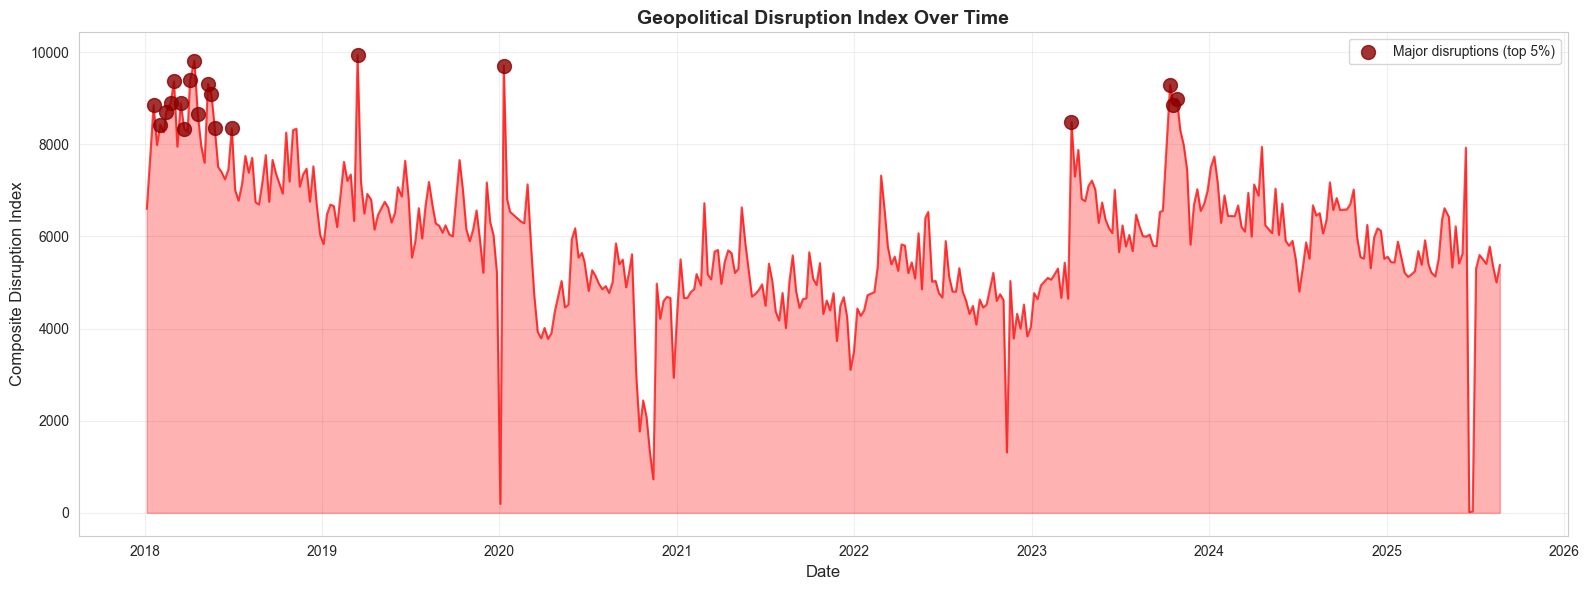

TOP 10 DISRUPTION WEEKS (Historical Black Swan Events)
            composite_disruption_index  maritime_conflict_events  extreme_crisis_events  black_swan_candidate_events
week_start                                                                                                          
2019-03-15                      9930.4                      6511                  26589                            1
2018-04-13                      9808.4                      4246                  28446                            2
2020-01-10                      9707.1                      4803                  27554                            0
2018-04-04                      9385.7                      5425                  25854                            5
2018-03-02                      9365.0                      5212                  26002                            2
2018-05-11                      9311.7                      4406                  26625                            6
2023-10-1

In [6]:
if has_news:
    # Create composite disruption index
    df_news['composite_disruption_index'] = (
        df_news['extreme_crisis_events'] * 0.3 +
        df_news['maritime_conflict_events'] * 0.3 +
        df_news['black_swan_candidate_events'] * 0.4
    )
    
    print("===" * 70)
    print("GEOPOLITICAL DISRUPTION ANALYSIS")
    print("===" * 70)
    print(f"GDELT data: {len(df_news)} weekly records")
    
    # Disruption over time
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(df_news.index, df_news['composite_disruption_index'], 
             linewidth=1.5, color='red', alpha=0.7)
    ax.fill_between(df_news.index, 0, df_news['composite_disruption_index'], 
                     alpha=0.3, color='red')
    
    # Highlight major disruptions
    threshold_95 = df_news['composite_disruption_index'].quantile(0.95)
    major_disruptions = df_news[df_news['composite_disruption_index'] > threshold_95]
    ax.scatter(major_disruptions.index, major_disruptions['composite_disruption_index'],
               color='darkred', s=100, alpha=0.8, label=f'Major disruptions (top 5%)', zorder=5)
    
    ax.set_title('Geopolitical Disruption Index Over Time', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Composite Disruption Index', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Top disruption weeks
    print("" + "===" * 70)
    print("TOP 10 DISRUPTION WEEKS (Historical Black Swan Events)")
    print("===" * 70)
    top_disruptions_cols = [
        'composite_disruption_index', 'maritime_conflict_events', 
        'extreme_crisis_events', 'black_swan_candidate_events'
    ]
    top_disruptions = df_news.nlargest(10, 'composite_disruption_index')[top_disruptions_cols]
    print(top_disruptions.to_string())
    
    print("Expected major events (2018-2025):")
    print("  • COVID-19 pandemic (2020-2021): Supply chain disruptions")
    print("  • Suez Canal blockage (March 2021): Ever Given incident")
    print("  • Russia-Ukraine war (Feb 2022+): Grain exports, fuel")
    print("  • Israel-Hamas conflict (Oct 2023+): Red Sea disruptions")
else:
    print("No disruption data available.")

## Step 5: Time-Series Visualization

Visualize the relationship between Europe Base Price and key disruption features over time.

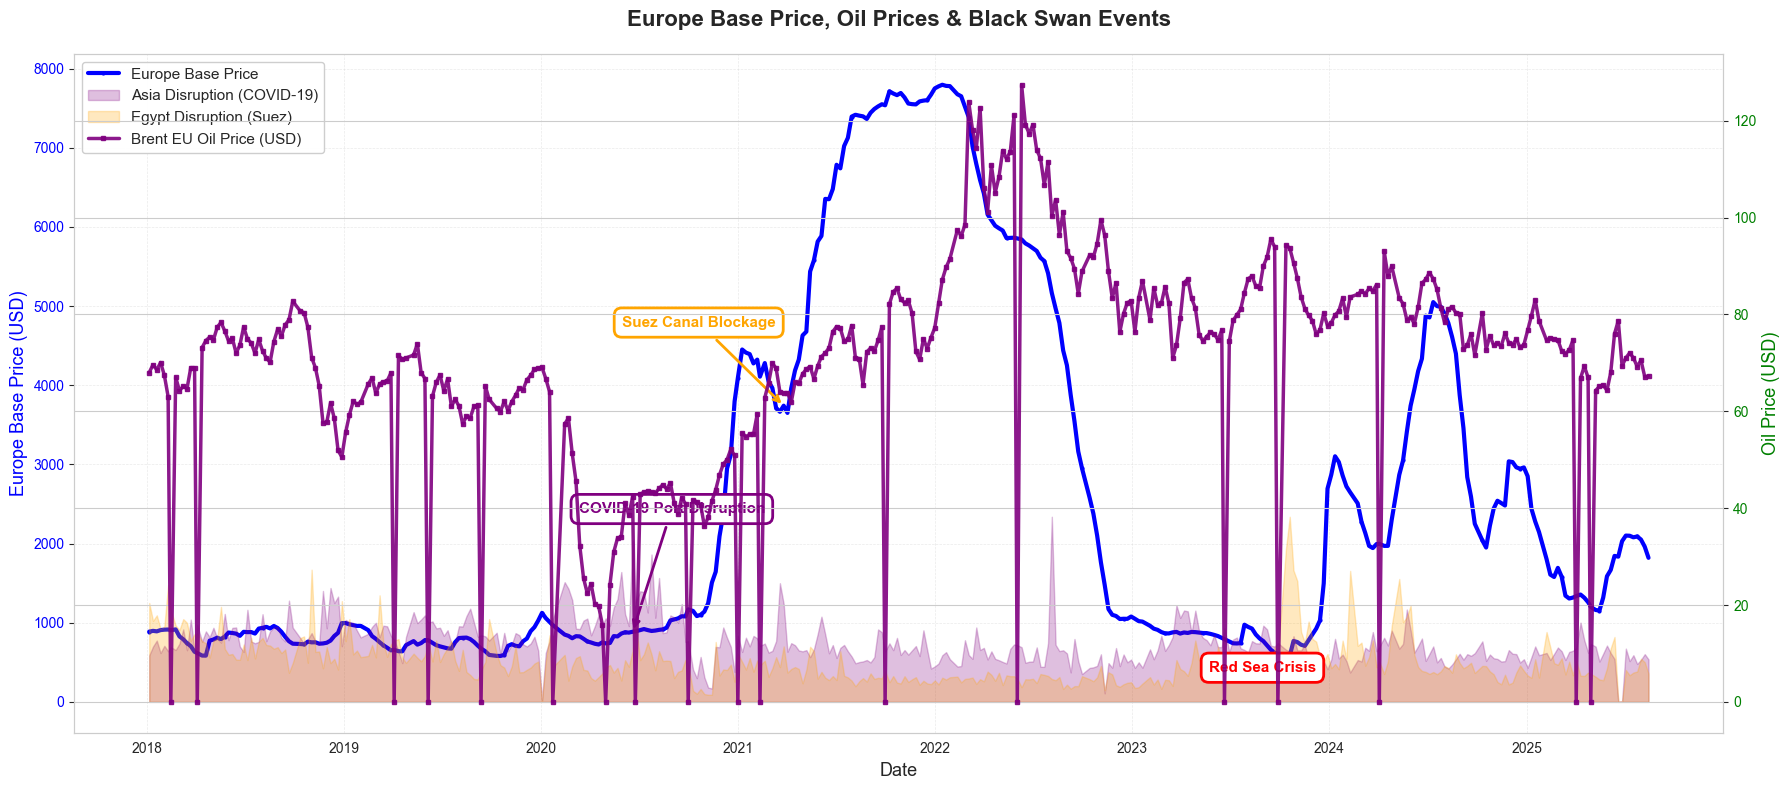

In [7]:
fig, ax1 = plt.subplots(figsize=(18, 8))

# Primary axis: Europe Base Price
color1 = 'blue'
ax1.set_xlabel('Date', fontsize=13)
ax1.set_ylabel('Europe Base Price (USD)', color=color1, fontsize=13)
ax1.plot(df_model_data.index, df_model_data['Europe_Base_Price'], 
         color=color1, linewidth=3.0, marker='o', markersize=2, markevery=10,
         label='Europe Base Price', zorder=1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create secondary axis for oil prices
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Price (USD)', color='green', fontsize=13)
ax2.tick_params(axis='y', labelcolor='green')

# Add WTI oil price to secondary axis
if 'WTI_Price' in df_model_data.columns:
    ax2.plot(df_model_data.index, df_model_data['WTI_Price'], 
             color='orange', linewidth=2.5, marker='o', markersize=3, 
             label='WTI Oil Price (USD)', alpha=0.9, zorder=3)

# Add Brent EU oil price to secondary axis
if 'Brent_Price' in df_model_data.columns:
    ax2.plot(df_model_data.index, df_model_data['Brent_Price'], 
             color='purple', linewidth=2.5, marker='s', markersize=3,
             label='Brent EU Oil Price (USD)', alpha=0.9, zorder=3)

# Plot key disruption features

# --- Asia Disruption (Unchanged) ---
if 'asia_disruption' in df_model_data.columns:
    asia_max = df_model_data['asia_disruption'].max()
    if asia_max > 0:
        asia_normalized = (df_model_data['asia_disruption'] / asia_max) * df_model_data['Europe_Base_Price'].max() * 0.3
        ax1.fill_between(df_model_data.index, 0, asia_normalized, 
                         color='purple', alpha=0.25, label='Asia Disruption (COVID-19)', zorder=2)

# --- Egypt Disruption (Unchanged) ---
if 'egypt_disruption' in df_model_data.columns:
    egypt_max = df_model_data['egypt_disruption'].max()
    if egypt_max > 0:
        egypt_normalized = (df_model_data['egypt_disruption'] / egypt_max) * df_model_data['Europe_Base_Price'].max() * 0.3
        ax1.fill_between(df_model_data.index, 0, egypt_normalized, 
                         color='orange', alpha=0.25, label='Egypt Disruption (Suez)', zorder=2)

# --- Annotations for major events ---

# --- Annotation for COVID-19 (Unchanged) ---
covid_peak = df_model_data[(df_model_data.index >= '2020-03-01') & (df_model_data.index <= '2021-12-31')]
if not covid_peak.empty and 'asia_disruption' in covid_peak.columns:
    covid_max_idx = covid_peak['asia_disruption'].idxmax() 
    covid_price = covid_peak.loc[covid_max_idx, 'Europe_Base_Price']
    ax1.annotate('COVID-19 Port Disruption', xy=(covid_max_idx, covid_price),
                 xytext=(covid_max_idx - pd.Timedelta(days=100), covid_price + 1500),
                 arrowprops=dict(arrowstyle='->', color='purple', lw=2),
                 fontsize=11, fontweight='bold', color='purple',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='purple', linewidth=2))

# ===================================================================
# FIXED SECTION
# This now finds the Friday *within* the blockage week (2021-03-23 to 2021-03-29)
# instead of looking for the exact (non-existent) start date.
# ===================================================================
suez_start_date = pd.Timestamp('2021-03-23')
suez_end_date = pd.Timestamp('2021-03-29')

# Find the row(s) *within* that week
suez_data_slice = df_model_data.loc[suez_start_date:suez_end_date]

if not suez_data_slice.empty:
    # Get the actual Friday index and price from that slice
    suez_friday_date = suez_data_slice.index[0] # This will be '2021-03-26'
    suez_price_point = suez_data_slice['Europe_Base_Price'].iloc[0] # Get price from that row

    # Point the arrow at the *actual* data point
    ax1.annotate('Suez Canal Blockage', xy=(suez_friday_date, suez_price_point),
                 xytext=(suez_friday_date - pd.Timedelta(days=300), suez_price_point + 1000), 
                 arrowprops=dict(arrowstyle='->', color='orange', lw=2),
                 fontsize=11, fontweight='bold', color='orange',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='orange', linewidth=2))
# ===================================================================

# --- Annotation for Red Sea Crisis (Unchanged) ---
red_sea_start = pd.Timestamp('2023-10-19')
if any(df_model_data.index >= red_sea_start):
    red_sea_data = df_model_data[df_model_data.index >= red_sea_start]
    if not red_sea_data.empty and 'egypt_disruption' in red_sea_data.columns:
        red_sea_max_idx = red_sea_data['egypt_disruption'].idxmax()
        red_sea_price = red_sea_data.loc[red_sea_max_idx, 'Europe_Base_Price']
        ax1.annotate('Red Sea Crisis', xy=(red_sea_max_idx, red_sea_price),
                     xytext=(red_sea_max_idx - pd.Timedelta(days=150), red_sea_price - 200),
                     arrowprops=dict(arrowstyle='->', color='red', lw=2),
                     fontsize=11, fontweight='bold', color='red',
                     bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='red', linewidth=2))

plt.title('Europe Base Price, Oil Prices & Black Swan Events', fontsize=16, fontweight='bold', pad=20)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11, framealpha=0.95, bbox_to_anchor=(0, 1))

# Improve grid styling
ax1.grid(True, alpha=0.4, linestyle='--', linewidth=0.5)
ax1.set_axisbelow(True)  # Put grid behind data

plt.tight_layout()
plt.show()


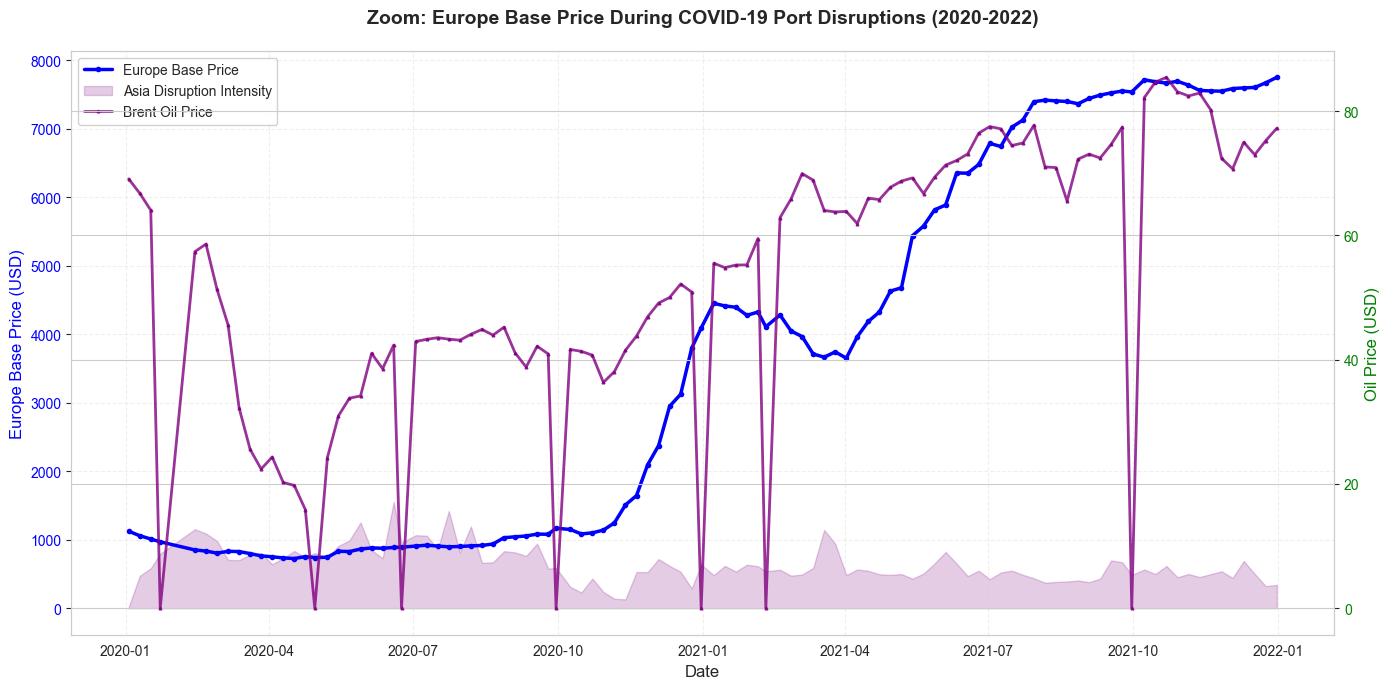

In [8]:
import matplotlib.pyplot as plt

# Zoom in on COVID-19 port disruptions period
covid_start = '2020-01-01'
covid_end = '2022-01-01'
df_covid_zoom = df_model_data.loc[covid_start:covid_end].copy()

fig, ax1 = plt.subplots(figsize=(14, 7))

# Primary axis: Europe Base Price
color1 = 'blue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Europe Base Price (USD)', color=color1, fontsize=12)
ax1.plot(df_covid_zoom.index, df_covid_zoom['Europe_Base_Price'], 
         color=color1, linewidth=2.5, marker='o', markersize=3, 
         label='Europe Base Price', zorder=1)
ax1.tick_params(axis='y', labelcolor=color1)

# Secondary axis for oil prices
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Price (USD)', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

# Add WTI oil price
if 'WTI_Price' in df_covid_zoom.columns:
    ax2.plot(df_covid_zoom.index, df_covid_zoom['WTI_Price'], 
             color='orange', linewidth=2, marker='s', markersize=2,
             label='WTI Oil Price', alpha=0.8, zorder=2)

# Add Brent oil price
if 'Brent_Price' in df_covid_zoom.columns:
    ax2.plot(df_covid_zoom.index, df_covid_zoom['Brent_Price'], 
             color='purple', linewidth=2, marker='^', markersize=2,
             label='Brent Oil Price', alpha=0.8, zorder=2)

# Highlight Asia disruption (COVID-related)
if 'asia_disruption' in df_covid_zoom.columns:
    asia_max = df_covid_zoom['asia_disruption'].max()
    if asia_max > 0:
        asia_normalized = (df_covid_zoom['asia_disruption'] / asia_max) * df_covid_zoom['Europe_Base_Price'].max() * 0.2
        ax1.fill_between(df_covid_zoom.index, 0, asia_normalized, 
                         color='purple', alpha=0.2, label='Asia Disruption Intensity', zorder=0)

plt.title('Zoom: Europe Base Price During COVID-19 Port Disruptions (2020-2022)', 
          fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10, framealpha=0.9)

ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

plt.tight_layout()
plt.show()

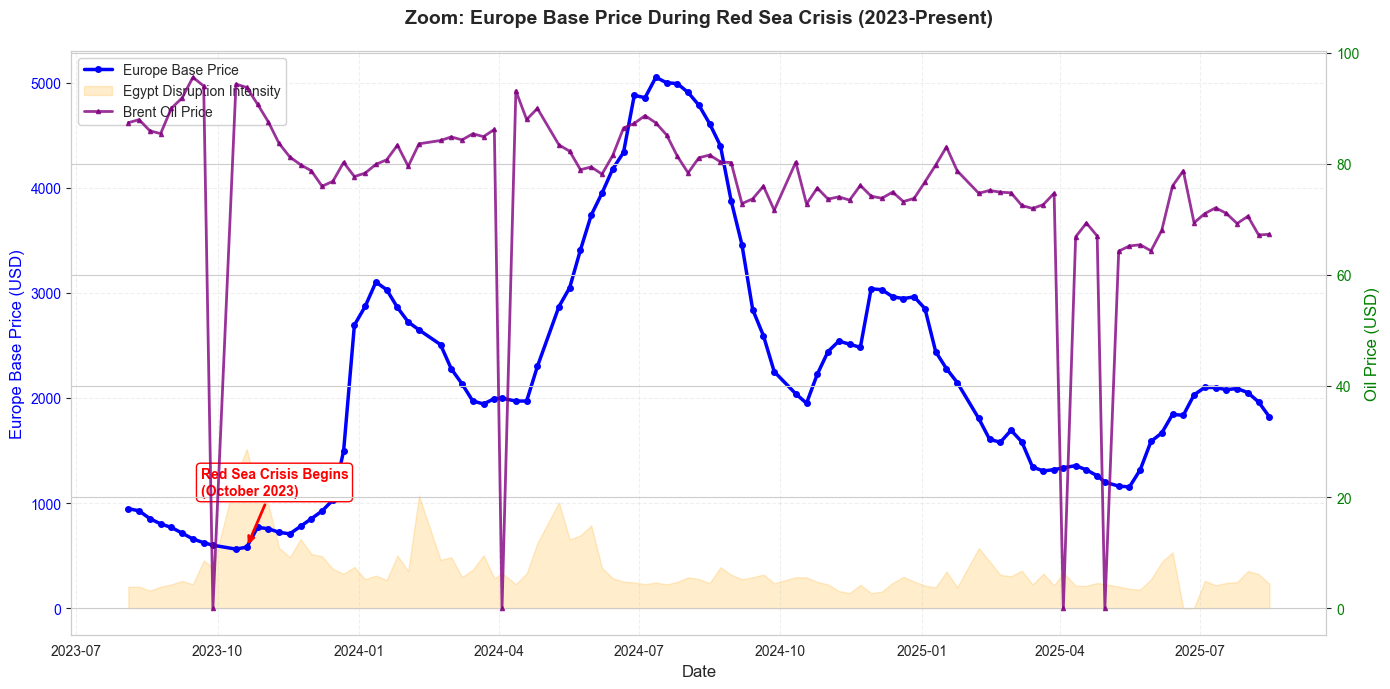

In [ ]:
import matplotlib.pyplot as plt

# Zoom in on Red Sea crisis period
red_sea_start = '2023-08-01'
red_sea_end = df_model_data.index.max()  # Up to latest data
df_red_sea_zoom = df_model_data.loc[red_sea_start:red_sea_end].copy()

fig, ax1 = plt.subplots(figsize=(14, 7))

# Primary axis: Europe Base Price
color1 = 'blue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Europe Base Price (USD)', color=color1, fontsize=12)
ax1.plot(df_red_sea_zoom.index, df_red_sea_zoom['Europe_Base_Price'], 
         color=color1, linewidth=2.5, marker='o', markersize=4, 
         label='Europe Base Price', zorder=1)
ax1.tick_params(axis='y', labelcolor=color1)

# Secondary axis for oil prices
ax2 = ax1.twinx()
ax2.set_ylabel('Brent Oil Price (USD)', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

# Add Brent oil price
if 'Brent_Price' in df_red_sea_zoom.columns:
    ax2.plot(df_red_sea_zoom.index, df_red_sea_zoom['Brent_Price'], 
             color='purple', linewidth=2, marker='^', markersize=3,
             label='Brent Oil Price', alpha=0.8, zorder=2)

# Highlight Egypt disruption (Suez-related)
if 'egypt_disruption' in df_red_sea_zoom.columns:
    egypt_max = df_red_sea_zoom['egypt_disruption'].max()
    if egypt_max > 0:
        egypt_normalized = (df_red_sea_zoom['egypt_disruption'] / egypt_max) * df_red_sea_zoom['Europe_Base_Price'].max() * 0.3
        ax1.fill_between(df_red_sea_zoom.index, 0, egypt_normalized, 
                         color='orange', alpha=0.2, label='Egypt Disruption Intensity', zorder=0)

# Annotate the crisis start
red_sea_crisis_start = pd.Timestamp('2023-10-19')
# Find the closest available date in the index
if df_red_sea_zoom.index.asof(red_sea_crisis_start) == red_sea_crisis_start:
    crisis_date_to_plot = red_sea_crisis_start
else:
    crisis_date_to_plot = df_red_sea_zoom.index[df_red_sea_zoom.index.searchsorted(red_sea_crisis_start)]

if crisis_date_to_plot in df_red_sea_zoom.index:
    crisis_price = df_red_sea_zoom.loc[crisis_date_to_plot, 'Europe_Base_Price']
    ax1.annotate('Red Sea Crisis Begins\n(October 2023)', 
                 xy=(crisis_date_to_plot, crisis_price),
                 xytext=(crisis_date_to_plot - pd.Timedelta(days=30), crisis_price + 500),
                 arrowprops=dict(arrowstyle='->', color='red', lw=2),
                 fontsize=10, fontweight='bold', color='red',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red'))

plt.title('Zoom: Europe Base Price During Red Sea Crisis (2023-Present)', 
          fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10, framealpha=0.9)

ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

plt.tight_layout()
plt.show()


## Market Conditions: From Stability to Extreme Volatility
The pre-COVID period (2018-2019) represented a stable baseline, with predictable seasonal patterns and an average shipping price of **$788**. This normal state was completely upended by the COVID-19 pandemic (2020-2021), which triggered a massive spike due to port closures, container shortages, and surging consumer demand. Prices during this period averaged **$3,938** (a 5x increase) and reached an unprecedented peak of **$7,751**, 884% above the baseline.

---

## Impact of Subsequent Crises
Other disruptions, while significant, were less extreme. The March 2021 Suez Canal blockage occurred when prices were already highly elevated from the pandemic (around $4,849). More recently, the Red Sea crisis (starting Oct 2023) caused prices to peak at $5,051. However, this crisis average ($2,428) is roughly half the COVID-era peak, and prices are already showing signs of declining as the market adapts.

---

## Relationship with Oil Prices
The analysis shows a moderate positive correlation (0.44-0.49) between container prices and Brent crude oil. This suggests that oil prices account for about 20-24% of the variance in shipping costs and are not the primary driver of the massive spikes observed.

---

## Implications for Modeling
These insights present both opportunities and challenges for modeling. The data shows clear, event-driven patterns with strong price momentum (spikes last for months), providing distinct training examples. The primary challenge is the **non-stationary nature** of the series, dominated by the historic COVID spike. This strongly suggests that a successful model will need to differentiate between "normal" and "crisis" market regimes.

## Step 6: Predictive Correlation Analysis

**Most important analysis** - showing which lagged features correlate with future price movements.

PREDICTIVE FEATURE CORRELATIONS WITH FUTURE PRICE
Top 15 most positively correlated features:
price_lag_1w                               0.991291
price_lag_2w                               0.982266
price_lag_1w_roll_mean_4w                  0.978534
price_lag_1w_roll_max_4w                   0.978403
price_lag_1w_roll_min_4w                   0.974826
price_lag_3w                               0.971182
price_lag_4w                               0.958106
price_lag_1w_roll_mean_8w                  0.957388
price_lag_1w_roll_max_8w                   0.956420
price_lag_1w_roll_min_8w                   0.947639
price_lag_5w                               0.943760
price_lag_6w                               0.928840
price_lag_7w                               0.913565
price_lag_8w                               0.898342
trade_ais_export_dry_bulk_lag_1w_lag_1w    0.372535
Name: price_1w_ahead, dtype: float64

Top 15 most negatively correlated features:
trade_restriction_events_lag_1w          -0.

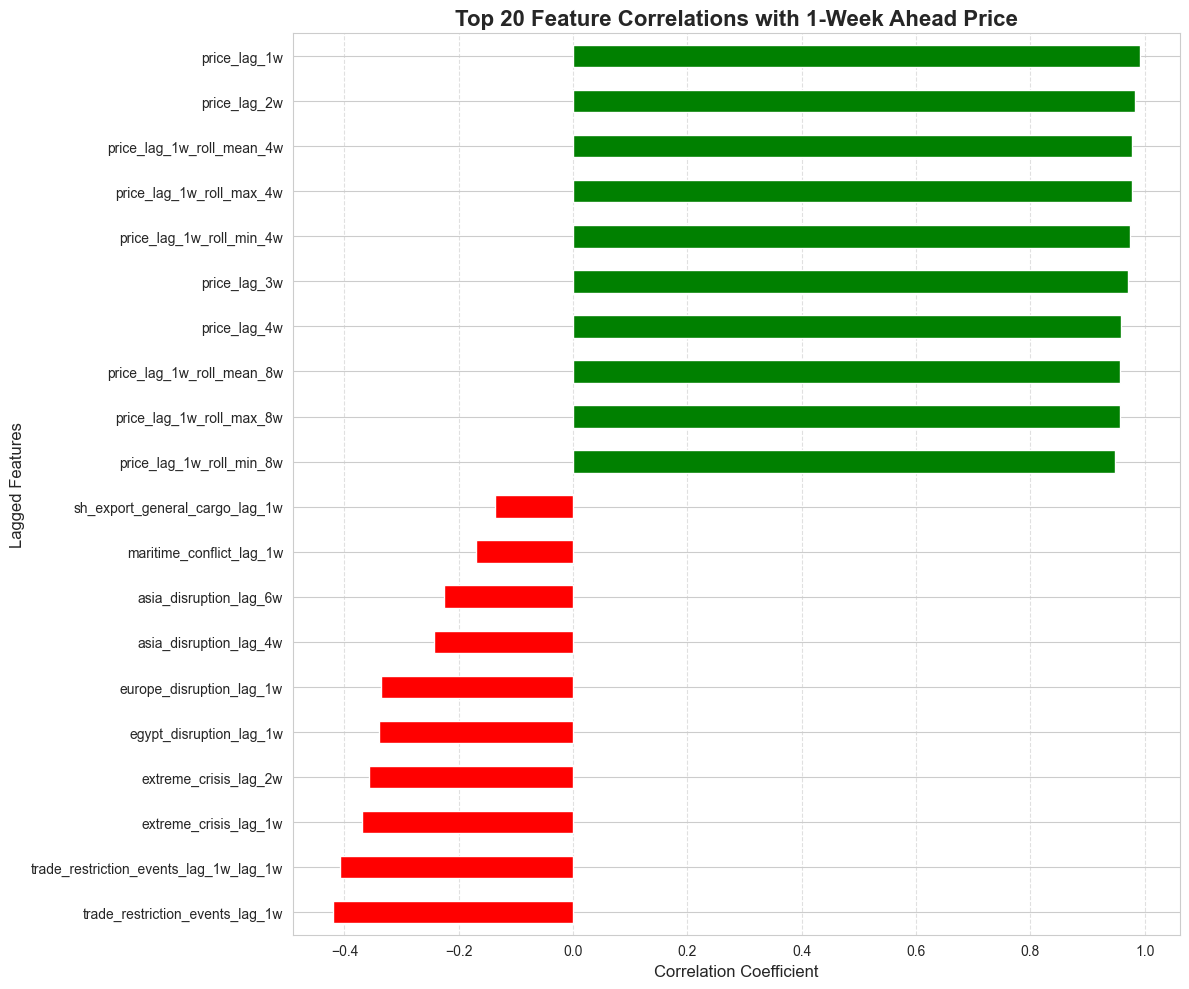

In [10]:
# Calculate correlations with the target variable
if 'price_1w_ahead' in df_model_data.columns:
    # Select only numeric columns for correlation calculation
    numeric_cols = df_model_data.select_dtypes(include=np.number).columns
    lag_features = [col for col in numeric_cols if '_lag_' in col]
    
    predictive_features = ['price_1w_ahead'] + lag_features
    
    # Ensure all features exist in the dataframe before calculating correlation
    predictive_features = [f for f in predictive_features if f in df_model_data.columns]
    
    correlation_data = df_model_data[predictive_features].corr()
    target_correlations = correlation_data['price_1w_ahead'].drop('price_1w_ahead')

    print("=" * 70)
    print("PREDICTIVE FEATURE CORRELATIONS WITH FUTURE PRICE")
    print("=" * 70)
    print("Top 15 most positively correlated features:")
    print(target_correlations.sort_values(ascending=False).head(15))
    print("\nTop 15 most negatively correlated features:")
    print(target_correlations.sort_values(ascending=True).head(15))

    # --- New Visualization: Bar Chart of Top Correlations ---
    
    # Get top 10 positive and top 10 negative correlations
    top_pos = target_correlations.nlargest(10)
    top_neg = target_correlations.nsmallest(10)
    top_corr = pd.concat([top_pos, top_neg])

    plt.figure(figsize=(12, 10))
    top_corr.sort_values().plot(kind='barh', color=top_corr.sort_values().gt(0).map({True: 'g', False: 'r'}))
    
    plt.title('Top 20 Feature Correlations with 1-Week Ahead Price', fontsize=16, fontweight='bold')
    plt.xlabel('Correlation Coefficient', fontsize=12)
    plt.ylabel('Lagged Features', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

else:
    print("Target variable 'price_1w_ahead' not found. Cannot perform correlation analysis.")

## Step 7: Stationarity Test

Test if the time series is stationary (statistical properties stable over time). Many models assume stationarity.

In [11]:
def check_stationarity(timeseries, column_name):
    print(f"=== Stationarity Analysis for {column_name} ===")
    
    # Augmented Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic', 'p-value', 'Lags Used', 'Observations'])
    
    print('Augmented Dickey-Fuller Test Results:')
    print(dfoutput)
    
    print('Critical Values:')
    for key, value in dftest[4].items():
        print(f'  {key}: {value:.3f}')
    
    # Interpretation
    print('Interpretation:')
    if dfoutput['p-value'] <= 0.05:
        print(f"  p-value = {dfoutput['p-value']:.4f} (< 0.05)")
        print("  Result: Series is STATIONARY (good for modeling)")
    else:
        print(f"  p-value = {dfoutput['p-value']:.4f} (> 0.05)")
        print("  Result: Series is NON-STATIONARY (may need differencing)")

# Check Europe Base Price stationarity
check_stationarity(df_freight['Europe_Base_Price'], 'Europe Base Price')

=== Stationarity Analysis for Europe Base Price ===
Augmented Dickey-Fuller Test Results:
Test Statistic     -2.088145
p-value             0.249308
Lags Used          17.000000
Observations      367.000000
dtype: float64
Critical Values:
  1%: -3.448
  5%: -2.869
  10%: -2.571
Interpretation:
  p-value = 0.2493 (> 0.05)
  Result: Series is NON-STATIONARY (may need differencing)


## Step 8: Summary and Next Steps

In [23]:
print("===" * 70)
print("FEATURE ENGINEERING SUMMARY")
print("===" * 70)

print(f"Modeling Dataset Ready:")
print(f"  • {len(df_model_data)} training samples")
print(f"  • {len(lag_features)} predictive lagged features")
print(f"  • Target: price_1w_ahead (1-week ahead prediction)")

print(f"\nKey Features Engineered:")
print(f"  • Price history lags: 1w, 2w, 4w (for baseline)")
print(f"  • Origin/Route lags: Egypt, Europe, Maritime (1-2 weeks)")
print(f"  • Destination lags: Asia disruption (4-6 weeks)")
print(f"  • Global lags: Black swan events (1-2 weeks)")
print(f"  • Shanghai port metrics: portcalls, volumes, congestion (1-week lags)")
print(f"  • Chokepoint metrics: vessel counts, capacity (1-2 week lags)")
print(f"  • China trade: monthly trade volumes/values (1-week lags)")

# Show correlation with target for lagged features
if 'price_1w_ahead' in df_model_data.columns:
    # Exclude Europe_Base_Price from features for correlation analysis
    feature_cols_for_analysis = [c for c in lag_features if c in df_model_data.columns]
    if len(feature_cols_for_analysis) > 0:
        predictive_features = ['price_1w_ahead'] + feature_cols_for_analysis
        correlation_data = df_model_data[predictive_features].corr()
        target_correlations = correlation_data['price_1w_ahead'].drop('price_1w_ahead')
        
        print(f"\nTop Predictive Features (by correlation):")
        top_features = target_correlations.abs().sort_values(ascending=False).head(5)
        for feature, corr in top_features.items():
            direction = "increases" if target_correlations[feature] > 0 else "decreases"
            print(f"  • {feature}: {target_correlations[feature]:.3f} (predicts price {direction})")

print(f"\nData Quality:")
if 'Europe_Base_Price' in df_model_data.columns:
    print(f"  • Price range: ${df_model_data['Europe_Base_Price'].min():.2f} to ${df_model_data['Europe_Base_Price'].max():.2f}")
    print(f"  • Price volatility (std): ${df_model_data['Europe_Base_Price'].std():.2f}")
print(f"  • No missing values in final dataset")

print("\n" + "="*70)
print("DATA LEAKAGE PREVENTION")
print("="*70)
print("✓ Europe_Base_Price (current week) will be EXCLUDED from modeling features")
print("✓ Only lagged features (past weeks) will be used for prediction")
print("✓ This ensures models cannot 'cheat' by seeing the current week's price")
print(f"✓ Excluded features: {exclude_features}")

print("" + "===" * 70)

# Save the processed dataset for modeling
output_path = 'data/processed/model_data.csv'
df_model_data.reset_index().to_csv(output_path, index=False)
print(f"✓ Saved final modeling dataset to '{output_path}'")
print(f"  Rows: {len(df_model_data)}, Features: {len(df_model_data.columns)}")
print(f"\n⚠️  IMPORTANT NOTE FOR 03_forecasting_pipeline.ipynb:")
print(f"  When loading this data, EXCLUDE these columns from features:")
print(f"  {exclude_features}")
print("\nReady for 03_forecasting_pipeline.ipynb")


FEATURE ENGINEERING SUMMARY
Modeling Dataset Ready:
  • 384 training samples
  • 98 predictive lagged features
  • Target: price_1w_ahead (1-week ahead prediction)

Key Features Engineered:
  • Price history lags: 1w, 2w, 4w (for baseline)
  • Origin/Route lags: Egypt, Europe, Maritime (1-2 weeks)
  • Destination lags: Asia disruption (4-6 weeks)
  • Global lags: Black swan events (1-2 weeks)
  • Shanghai port metrics: portcalls, volumes, congestion (1-week lags)
  • Chokepoint metrics: vessel counts, capacity (1-2 week lags)
  • China trade: monthly trade volumes/values (1-week lags)

Top Predictive Features (by correlation):
  • price_lag_1w: 0.991 (predicts price increases)
  • price_lag_2w: 0.982 (predicts price increases)
  • price_lag_1w_roll_mean_4w: 0.979 (predicts price increases)
  • price_lag_1w_roll_max_4w: 0.978 (predicts price increases)
  • price_lag_1w_roll_min_4w: 0.975 (predicts price increases)

Data Quality:
  • Price range: $562.00 to $7797.00
  • Price volatility 

FEATURE IMPORTANCE ANALYSIS
Feature matrix: 384 samples, 355 features
Target: price_1w_ahead (1-week ahead Europe Base Price)

--- Top 15 Features by Absolute Correlation with Target ---
Europe_Base_Price            0.997278
price_lag_1w                 0.991291
SCFI_Index                   0.984477
price_lag_2w                 0.982266
price_lag_1w_roll_mean_4w    0.978534
price_lag_1w_roll_max_4w     0.978403
price_lag_1w_roll_min_4w     0.974826
price_lag_3w                 0.971182
price_lag_4w                 0.958106
price_lag_1w_roll_mean_8w    0.957388
price_lag_1w_roll_max_8w     0.956420
price_lag_1w_roll_min_8w     0.947639
price_lag_5w                 0.943760
price_lag_6w                 0.928840
price_lag_7w                 0.913565
dtype: float64

--- Top 15 Features by XGBoost Importance ---
                                feature  importance
                      Europe_Base_Price    0.612474
                             SCFI_Index    0.239153
             trade_ais_ex

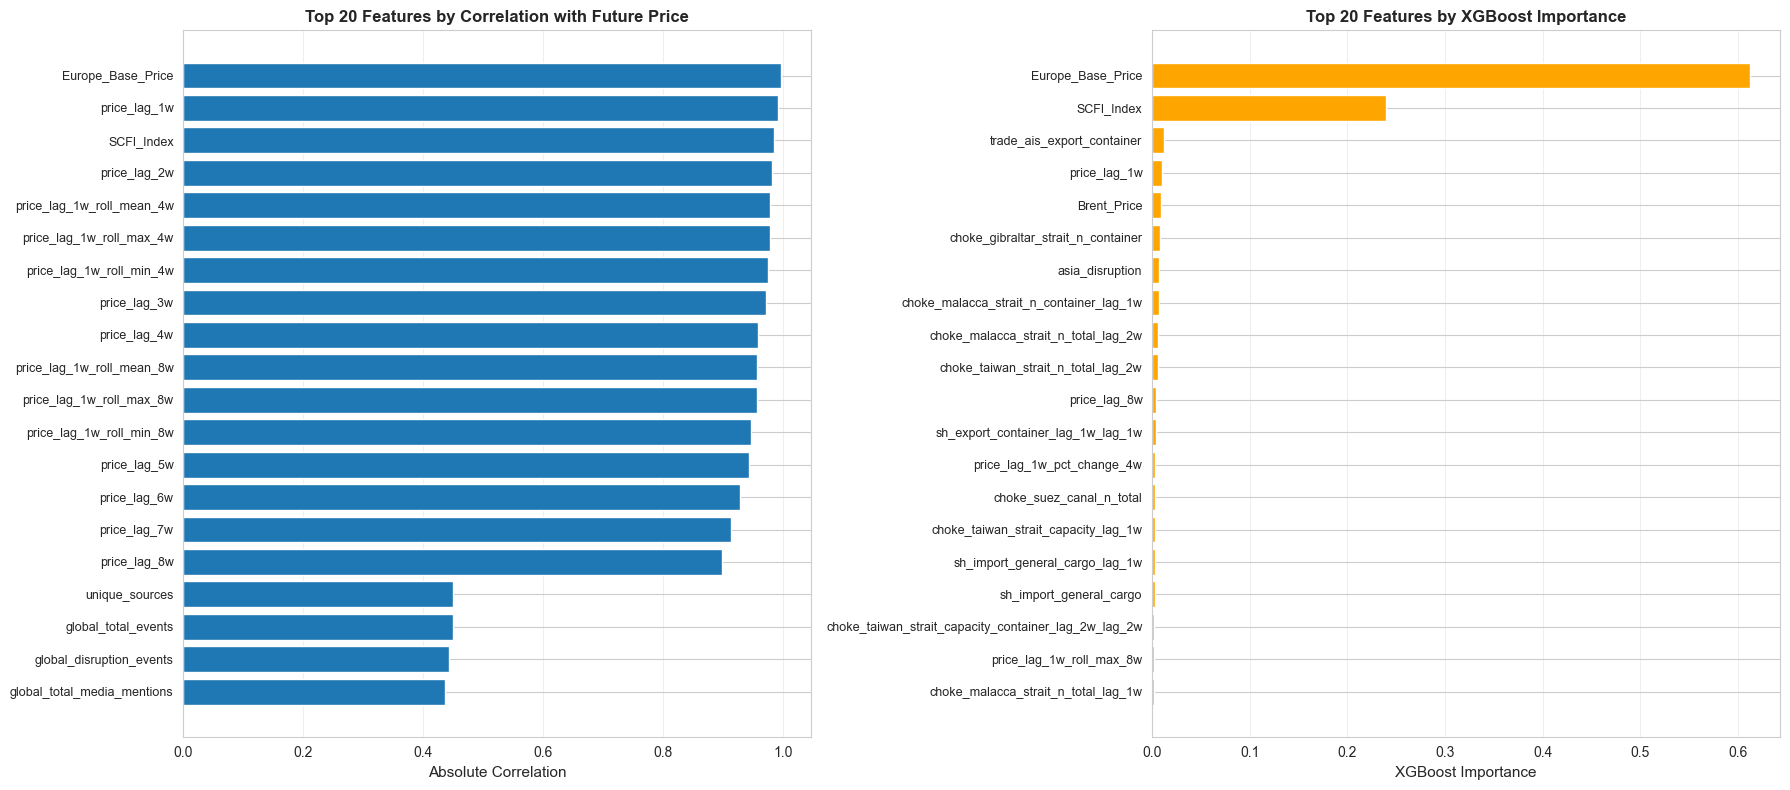


FEATURE IMPORTANCE COMPLETE


In [13]:
print("=" * 70)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Prepare feature matrix and target
if 'price_1w_ahead' not in df_model_data.columns:
    print("Error: price_1w_ahead target not found. Cannot run feature importance.")
else:
    # Select numeric features only (exclude target)
    feature_cols = [c for c in df_model_data.columns 
                    if c != 'price_1w_ahead' and pd.api.types.is_numeric_dtype(df_model_data[c])]
    
    X = df_model_data[feature_cols]
    y = df_model_data['price_1w_ahead']
    
    print(f"Feature matrix: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Target: {y.name} (1-week ahead Europe Base Price)")
    
    # 1) Correlation-based importance
    print("\n--- Top 15 Features by Absolute Correlation with Target ---")
    correlations = X.corrwith(y).abs().sort_values(ascending=False)
    print(correlations.head(15))
    
    # 2) XGBoost feature importance (if we have enough data)
    if len(X) > 50:
        try:
            from xgboost import XGBRegressor
            
            # Train simple XGBoost model
            model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, 
                                 random_state=42, verbosity=0)
            model.fit(X, y)
            
            # Get feature importance
            importance_df = pd.DataFrame({
                'feature': feature_cols,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("\n--- Top 15 Features by XGBoost Importance ---")
            print(importance_df.head(15).to_string(index=False))
            
            # Plot top 20 features
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
            
            # Correlation plot
            top_corr = correlations.head(20)
            ax1.barh(range(len(top_corr)), top_corr.values)
            ax1.set_yticks(range(len(top_corr)))
            ax1.set_yticklabels(top_corr.index, fontsize=9)
            ax1.invert_yaxis()
            ax1.set_xlabel('Absolute Correlation', fontsize=11)
            ax1.set_title('Top 20 Features by Correlation with Future Price', fontsize=12, fontweight='bold')
            ax1.grid(axis='x', alpha=0.3)
            
            # XGBoost importance plot
            top_xgb = importance_df.head(20)
            ax2.barh(range(len(top_xgb)), top_xgb['importance'].values, color='orange')
            ax2.set_yticks(range(len(top_xgb)))
            ax2.set_yticklabels(top_xgb['feature'], fontsize=9)
            ax2.invert_yaxis()
            ax2.set_xlabel('XGBoost Importance', fontsize=11)
            ax2.set_title('Top 20 Features by XGBoost Importance', fontsize=12, fontweight='bold')
            ax2.grid(axis='x', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print("\n" + "=" * 70)
            print("FEATURE IMPORTANCE COMPLETE")
            print("=" * 70)
            
        except ImportError:
            print("\nXGBoost not installed. Run: pip install xgboost")
            print("Showing correlation-based importance only.")
    else:
        print(f"\nDataset too small ({len(X)} samples) for reliable XGBoost training.")
        print("Correlation analysis shown above.")

In [14]:
# Create lagged features based on shipping route timing
print("="*70)
print("CREATING TIME-LAGGED FEATURES (PREVENT DATA LEAKAGE)")
print("="*70)

# ====================================================================
# IMPORTANT: All features must be from PAST weeks only!
# We use shift(1) or higher to ensure features are BEFORE the target week
# ====================================================================

# CRITICAL FIX: Create lagged version of Europe_Base_Price for baseline comparison
# This is the ONLY price feature we'll include (from 1 week ago)
if 'Europe_Base_Price' in df_combined.columns:
    df_combined['price_lag_1w'] = df_combined['Europe_Base_Price'].shift(1)
    df_combined['price_lag_2w'] = df_combined['Europe_Base_Price'].shift(2)
    df_combined['price_lag_4w'] = df_combined['Europe_Base_Price'].shift(4)
    print("✓ Created price lags: 1w, 2w, 4w (for baseline comparison)")

# Existing disruption-based lags (retain original logic)
if 'egypt_disruption' in df_combined.columns:
    df_combined['egypt_disruption_lag_1w'] = df_combined['egypt_disruption'].shift(1)

if 'europe_disruption' in df_combined.columns:
    df_combined['europe_disruption_lag_1w'] = df_combined['europe_disruption'].shift(1)

if 'maritime_conflict_events' in df_combined.columns:
    df_combined['maritime_conflict_lag_1w'] = df_combined['maritime_conflict_events'].shift(1)

# Destination Lags (4-6 weeks)
if 'asia_disruption' in df_combined.columns:
    df_combined['asia_disruption_lag_4w'] = df_combined['asia_disruption'].shift(4)
    df_combined['asia_disruption_lag_6w'] = df_combined['asia_disruption'].shift(6)

# Global Lags (1-2 weeks)
if 'extreme_crisis_events' in df_combined.columns:
    df_combined['extreme_crisis_lag_1w'] = df_combined['extreme_crisis_events'].shift(1)
    df_combined['extreme_crisis_lag_2w'] = df_combined['extreme_crisis_events'].shift(2)

# New features from Shanghai port weekly (origin) - create immediate and lag features
sh_cols = [c for c in df_combined.columns if c.startswith('sh_')]
if sh_cols:
    print(f"Found Shanghai-derived columns: {sh_cols}")
    # Example: create 1-week lag for container portcalls mean if present
    if 'sh_portcalls_container' in df_combined.columns:
        df_combined['sh_portcalls_container_lag_1w'] = df_combined['sh_portcalls_container'].shift(1)
    # Generic: create 1-week lag for all sh_ numeric columns
    for c in sh_cols:
        if pd.api.types.is_numeric_dtype(df_combined[c]):
            df_combined[f"{c}_lag_1w"] = df_combined[c].shift(1)

# New features from chokepoints - pick Suez and Malacca related columns if present
choke_cols = [c for c in df_combined.columns if c.startswith('choke_')]
if choke_cols:
    print(f"Found chokepoint-derived columns (sample): {choke_cols[:6]}")
    # Create short lags (1-2 weeks) for chokepoint stats
    for c in choke_cols:
        if pd.api.types.is_numeric_dtype(df_combined[c]):
            df_combined[f"{c}_lag_1w"] = df_combined[c].shift(1)
            df_combined[f"{c}_lag_2w"] = df_combined[c].shift(2)

# Trade-related features
trade_cols = [c for c in df_combined.columns if c.startswith('trade_')]
if trade_cols:
    print(f"Found trade-derived columns: {trade_cols}")
    # Create month-over-month growth for trade_value if present
    if 'trade_trade_value' in df_combined.columns:
        df_combined['trade_value_mom'] = df_combined['trade_trade_value'].pct_change().fillna(0)
    # Create 1-week lag of trade signals
    for c in trade_cols:
        if pd.api.types.is_numeric_dtype(df_combined[c]):
            df_combined[f"{c}_lag_1w"] = df_combined[c].shift(1)

# Collect lag feature names
lag_features = [col for col in df_combined.columns if '_lag_' in col]
print(f"\n✓ Created {len(lag_features)} lagged features")
# Print a short sample
print(f"Sample lagged features: {lag_features[:12]}")

# ====================================================================
# REMOVE CURRENT WEEK FEATURES TO PREVENT LEAKAGE
# ====================================================================
print("\n" + "="*70)
print("REMOVING FEATURES THAT COULD CAUSE DATA LEAKAGE")
print("="*70)

# Features to exclude (current week's data that shouldn't be used for prediction)
exclude_features = []

# 1. Remove current week's price (CRITICAL!)
if 'Europe_Base_Price' in df_combined.columns:
    exclude_features.append('Europe_Base_Price')
    print("✓ Excluding Europe_Base_Price (current week)")

# 2. Remove non-lagged versions of features (use only lagged versions)
non_lag_features_to_remove = []
for col in df_combined.columns:
    # If a column has no lag suffix and a lagged version exists, remove the non-lagged
    if '_lag_' not in col and col != 'price_1w_ahead':
        # Check if there's a lagged version
        if f"{col}_lag_1w" in df_combined.columns or f"{col}_lag_2w" in df_combined.columns:
            # This is a feature that has lagged versions - keep only lagged
            if col not in ['Europe_Base_Price']:  # Already handled
                non_lag_features_to_remove.append(col)

# For now, keep non-lagged features but issue warning
if len(non_lag_features_to_remove) > 10:
    print(f"⚠️  Warning: {len(non_lag_features_to_remove)} features have no lag (same-week data)")
    print(f"    Sample: {non_lag_features_to_remove[:5]}")
    print(f"    This may cause data leakage if these features are known same-week")

print(f"\n✓ Will exclude {len(exclude_features)} feature(s) from modeling")

# Clean dataset by dropping rows with NaN introduced by lagging and target shifting
before_clean = len(df_combined)
df_model_data = df_combined.dropna()
after_clean = len(df_model_data)

print(f"\n" + "="*70)
print(f"FINAL MODELING DATASET")
print(f"="*70)
print(f"✓ {after_clean} rows, {len(df_model_data.columns)} total columns")
print(f"✓ Date range: {df_model_data.index.min().date()} to {df_model_data.index.max().date()}")
print(f"✓ Removed {before_clean - after_clean} rows due to lagging/dropna")
print(f"✓ Features to exclude in modeling: {exclude_features}")


CREATING TIME-LAGGED FEATURES (PREVENT DATA LEAKAGE)
✓ Created price lags: 1w, 2w, 4w (for baseline comparison)
Found Shanghai-derived columns: ['sh_portcalls_container', 'sh_portcalls_dry_bulk', 'sh_portcalls_general_cargo', 'sh_portcalls_roro', 'sh_portcalls_tanker', 'sh_portcalls_cargo', 'sh_portcalls', 'sh_import_container', 'sh_import_dry_bulk', 'sh_import_general_cargo', 'sh_import_roro', 'sh_import_tanker', 'sh_import_cargo', 'sh_import', 'sh_export_container', 'sh_export_dry_bulk', 'sh_export_general_cargo', 'sh_export_roro', 'sh_export_tanker', 'sh_export_cargo', 'sh_export', 'sh_portcalls_container_norm', 'sh_portcalls_container_lag_1w', 'sh_portcalls_dry_bulk_lag_1w', 'sh_portcalls_general_cargo_lag_1w', 'sh_portcalls_roro_lag_1w', 'sh_portcalls_tanker_lag_1w', 'sh_portcalls_cargo_lag_1w', 'sh_portcalls_lag_1w', 'sh_import_container_lag_1w', 'sh_import_dry_bulk_lag_1w', 'sh_import_general_cargo_lag_1w', 'sh_import_roro_lag_1w', 'sh_import_tanker_lag_1w', 'sh_import_cargo_lag

## Step 4: Disruption Events Analysis

Analyze geopolitical disruption patterns and their relationship to container prices.

GEOPOLITICAL DISRUPTION ANALYSIS
GDELT data: 385 weekly records


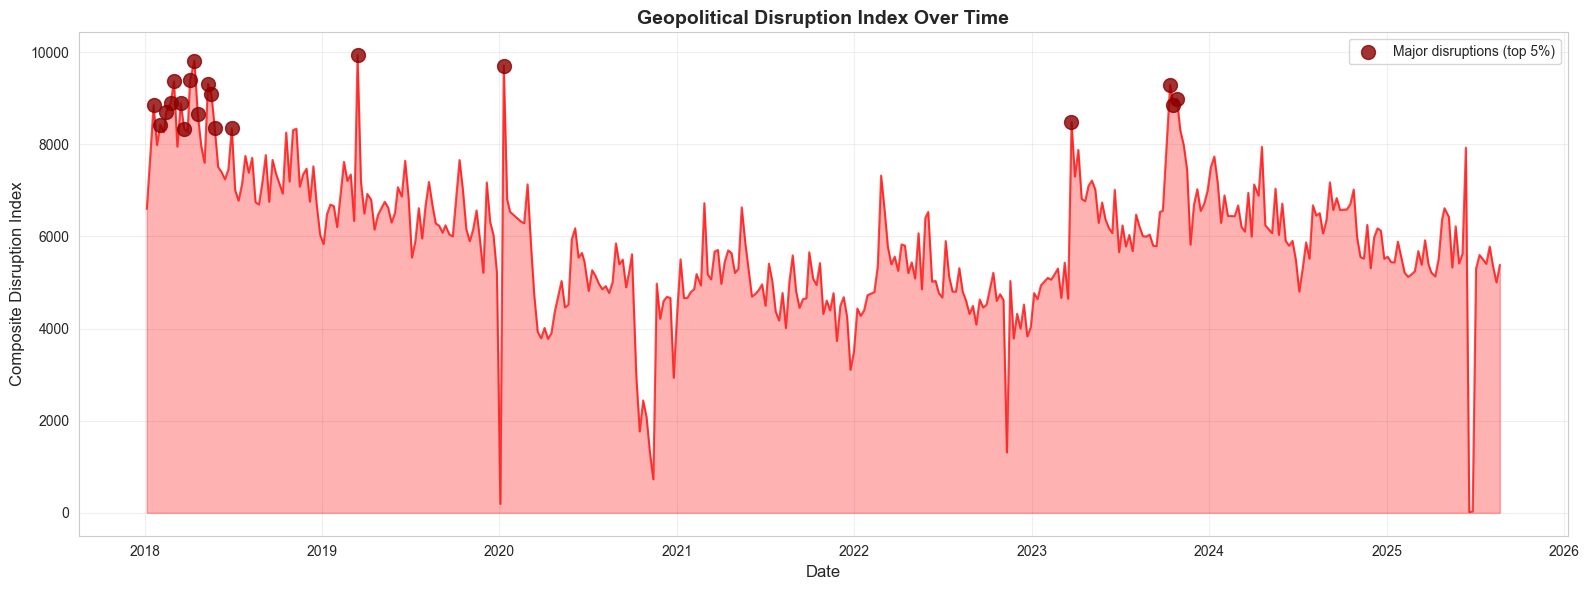

TOP 10 DISRUPTION WEEKS (Historical Black Swan Events)
            composite_disruption_index  maritime_conflict_events  extreme_crisis_events  black_swan_candidate_events
week_start                                                                                                          
2019-03-15                      9930.4                      6511                  26589                            1
2018-04-13                      9808.4                      4246                  28446                            2
2020-01-10                      9707.1                      4803                  27554                            0
2018-04-04                      9385.7                      5425                  25854                            5
2018-03-02                      9365.0                      5212                  26002                            2
2018-05-11                      9311.7                      4406                  26625                            6
2023-10-1

In [15]:
if has_news:
    # Create composite disruption index
    df_news['composite_disruption_index'] = (
        df_news['extreme_crisis_events'] * 0.3 +
        df_news['maritime_conflict_events'] * 0.3 +
        df_news['black_swan_candidate_events'] * 0.4
    )
    
    print("===" * 70)
    print("GEOPOLITICAL DISRUPTION ANALYSIS")
    print("===" * 70)
    print(f"GDELT data: {len(df_news)} weekly records")
    
    # Disruption over time
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(df_news.index, df_news['composite_disruption_index'], 
             linewidth=1.5, color='red', alpha=0.7)
    ax.fill_between(df_news.index, 0, df_news['composite_disruption_index'], 
                     alpha=0.3, color='red')
    
    # Highlight major disruptions
    threshold_95 = df_news['composite_disruption_index'].quantile(0.95)
    major_disruptions = df_news[df_news['composite_disruption_index'] > threshold_95]
    ax.scatter(major_disruptions.index, major_disruptions['composite_disruption_index'],
               color='darkred', s=100, alpha=0.8, label=f'Major disruptions (top 5%)', zorder=5)
    
    ax.set_title('Geopolitical Disruption Index Over Time', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Composite Disruption Index', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Top disruption weeks
    print("" + "===" * 70)
    print("TOP 10 DISRUPTION WEEKS (Historical Black Swan Events)")
    print("===" * 70)
    top_disruptions_cols = [
        'composite_disruption_index', 'maritime_conflict_events', 
        'extreme_crisis_events', 'black_swan_candidate_events'
    ]
    top_disruptions = df_news.nlargest(10, 'composite_disruption_index')[top_disruptions_cols]
    print(top_disruptions.to_string())
    
    print("Expected major events (2018-2025):")
    print("  • COVID-19 pandemic (2020-2021): Supply chain disruptions")
    print("  • Suez Canal blockage (March 2021): Ever Given incident")
    print("  • Russia-Ukraine war (Feb 2022+): Grain exports, fuel")
    print("  • Israel-Hamas conflict (Oct 2023+): Red Sea disruptions")
else:
    print("No disruption data available.")

## Step 5: Time-Series Visualization

Visualize the relationship between Europe Base Price and key disruption features over time.

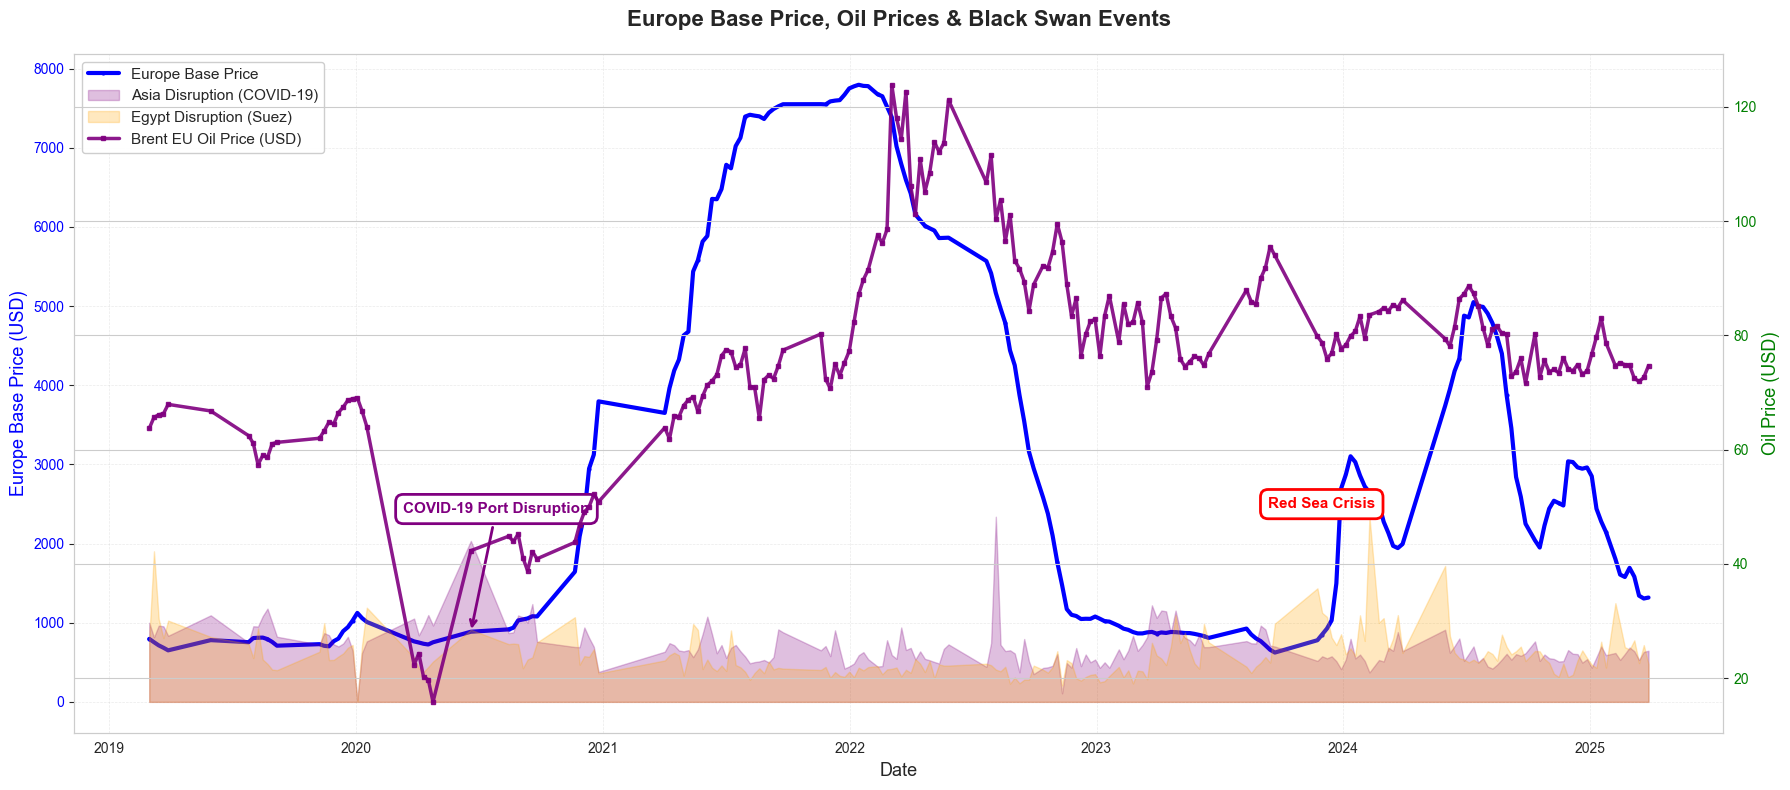

In [16]:
fig, ax1 = plt.subplots(figsize=(18, 8))

# Primary axis: Europe Base Price
color1 = 'blue'
ax1.set_xlabel('Date', fontsize=13)
ax1.set_ylabel('Europe Base Price (USD)', color=color1, fontsize=13)
ax1.plot(df_model_data.index, df_model_data['Europe_Base_Price'], 
         color=color1, linewidth=3.0, marker='o', markersize=2, markevery=10,
         label='Europe Base Price', zorder=1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create secondary axis for oil prices
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Price (USD)', color='green', fontsize=13)
ax2.tick_params(axis='y', labelcolor='green')

# Add WTI oil price to secondary axis
if 'WTI_Price' in df_model_data.columns:
    ax2.plot(df_model_data.index, df_model_data['WTI_Price'], 
             color='orange', linewidth=2.5, marker='o', markersize=3, 
             label='WTI Oil Price (USD)', alpha=0.9, zorder=3)

# Add Brent EU oil price to secondary axis
if 'Brent_Price' in df_model_data.columns:
    ax2.plot(df_model_data.index, df_model_data['Brent_Price'], 
             color='purple', linewidth=2.5, marker='s', markersize=3,
             label='Brent EU Oil Price (USD)', alpha=0.9, zorder=3)

# Plot key disruption features

# --- Asia Disruption (Unchanged) ---
if 'asia_disruption' in df_model_data.columns:
    asia_max = df_model_data['asia_disruption'].max()
    if asia_max > 0:
        asia_normalized = (df_model_data['asia_disruption'] / asia_max) * df_model_data['Europe_Base_Price'].max() * 0.3
        ax1.fill_between(df_model_data.index, 0, asia_normalized, 
                         color='purple', alpha=0.25, label='Asia Disruption (COVID-19)', zorder=2)

# --- Egypt Disruption (Unchanged) ---
if 'egypt_disruption' in df_model_data.columns:
    egypt_max = df_model_data['egypt_disruption'].max()
    if egypt_max > 0:
        egypt_normalized = (df_model_data['egypt_disruption'] / egypt_max) * df_model_data['Europe_Base_Price'].max() * 0.3
        ax1.fill_between(df_model_data.index, 0, egypt_normalized, 
                         color='orange', alpha=0.25, label='Egypt Disruption (Suez)', zorder=2)

# --- Annotations for major events ---

# --- Annotation for COVID-19 (Unchanged) ---
covid_peak = df_model_data[(df_model_data.index >= '2020-03-01') & (df_model_data.index <= '2021-12-31')]
if not covid_peak.empty and 'asia_disruption' in covid_peak.columns:
    covid_max_idx = covid_peak['asia_disruption'].idxmax() 
    covid_price = covid_peak.loc[covid_max_idx, 'Europe_Base_Price']
    ax1.annotate('COVID-19 Port Disruption', xy=(covid_max_idx, covid_price),
                 xytext=(covid_max_idx - pd.Timedelta(days=100), covid_price + 1500),
                 arrowprops=dict(arrowstyle='->', color='purple', lw=2),
                 fontsize=11, fontweight='bold', color='purple',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='purple', linewidth=2))

# ===================================================================
# FIXED SECTION
# This now finds the Friday *within* the blockage week (2021-03-23 to 2021-03-29)
# instead of looking for the exact (non-existent) start date.
# ===================================================================
suez_start_date = pd.Timestamp('2021-03-23')
suez_end_date = pd.Timestamp('2021-03-29')

# Find the row(s) *within* that week
suez_data_slice = df_model_data.loc[suez_start_date:suez_end_date]

if not suez_data_slice.empty:
    # Get the actual Friday index and price from that slice
    suez_friday_date = suez_data_slice.index[0] # This will be '2021-03-26'
    suez_price_point = suez_data_slice['Europe_Base_Price'].iloc[0] # Get price from that row

    # Point the arrow at the *actual* data point
    ax1.annotate('Suez Canal Blockage', xy=(suez_friday_date, suez_price_point),
                 xytext=(suez_friday_date - pd.Timedelta(days=300), suez_price_point + 1000), 
                 arrowprops=dict(arrowstyle='->', color='orange', lw=2),
                 fontsize=11, fontweight='bold', color='orange',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='orange', linewidth=2))
# ===================================================================

# --- Annotation for Red Sea Crisis (Unchanged) ---
red_sea_start = pd.Timestamp('2023-10-19')
if any(df_model_data.index >= red_sea_start):
    red_sea_data = df_model_data[df_model_data.index >= red_sea_start]
    if not red_sea_data.empty and 'egypt_disruption' in red_sea_data.columns:
        red_sea_max_idx = red_sea_data['egypt_disruption'].idxmax()
        red_sea_price = red_sea_data.loc[red_sea_max_idx, 'Europe_Base_Price']
        ax1.annotate('Red Sea Crisis', xy=(red_sea_max_idx, red_sea_price),
                     xytext=(red_sea_max_idx - pd.Timedelta(days=150), red_sea_price - 200),
                     arrowprops=dict(arrowstyle='->', color='red', lw=2),
                     fontsize=11, fontweight='bold', color='red',
                     bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='red', linewidth=2))

plt.title('Europe Base Price, Oil Prices & Black Swan Events', fontsize=16, fontweight='bold', pad=20)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11, framealpha=0.95, bbox_to_anchor=(0, 1))

# Improve grid styling
ax1.grid(True, alpha=0.4, linestyle='--', linewidth=0.5)
ax1.set_axisbelow(True)  # Put grid behind data

plt.tight_layout()
plt.show()


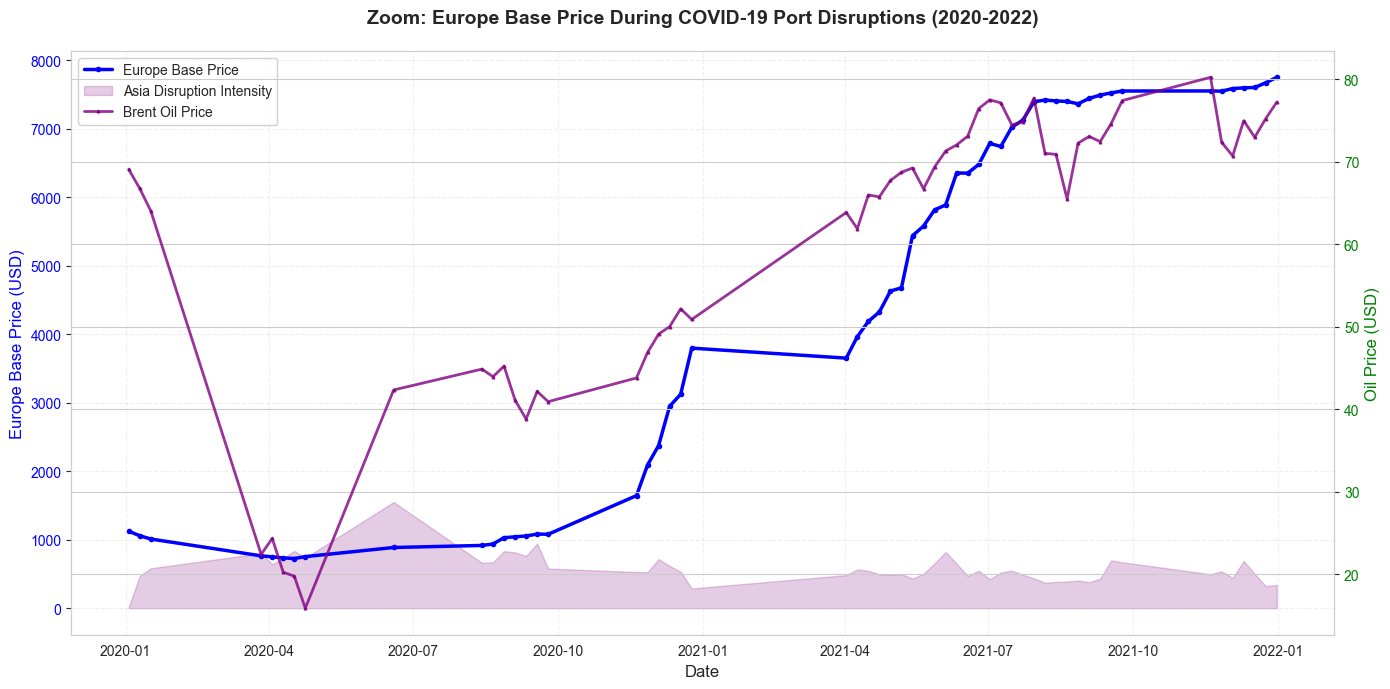

In [17]:
import matplotlib.pyplot as plt

# Zoom in on COVID-19 port disruptions period
covid_start = '2020-01-01'
covid_end = '2022-01-01'
df_covid_zoom = df_model_data.loc[covid_start:covid_end].copy()

fig, ax1 = plt.subplots(figsize=(14, 7))

# Primary axis: Europe Base Price
color1 = 'blue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Europe Base Price (USD)', color=color1, fontsize=12)
ax1.plot(df_covid_zoom.index, df_covid_zoom['Europe_Base_Price'], 
         color=color1, linewidth=2.5, marker='o', markersize=3, 
         label='Europe Base Price', zorder=1)
ax1.tick_params(axis='y', labelcolor=color1)

# Secondary axis for oil prices
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Price (USD)', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

# Add WTI oil price
if 'WTI_Price' in df_covid_zoom.columns:
    ax2.plot(df_covid_zoom.index, df_covid_zoom['WTI_Price'], 
             color='orange', linewidth=2, marker='s', markersize=2,
             label='WTI Oil Price', alpha=0.8, zorder=2)

# Add Brent oil price
if 'Brent_Price' in df_covid_zoom.columns:
    ax2.plot(df_covid_zoom.index, df_covid_zoom['Brent_Price'], 
             color='purple', linewidth=2, marker='^', markersize=2,
             label='Brent Oil Price', alpha=0.8, zorder=2)

# Highlight Asia disruption (COVID-related)
if 'asia_disruption' in df_covid_zoom.columns:
    asia_max = df_covid_zoom['asia_disruption'].max()
    if asia_max > 0:
        asia_normalized = (df_covid_zoom['asia_disruption'] / asia_max) * df_covid_zoom['Europe_Base_Price'].max() * 0.2
        ax1.fill_between(df_covid_zoom.index, 0, asia_normalized, 
                         color='purple', alpha=0.2, label='Asia Disruption Intensity', zorder=0)

plt.title('Zoom: Europe Base Price During COVID-19 Port Disruptions (2020-2022)', 
          fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10, framealpha=0.9)

ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

plt.tight_layout()
plt.show()

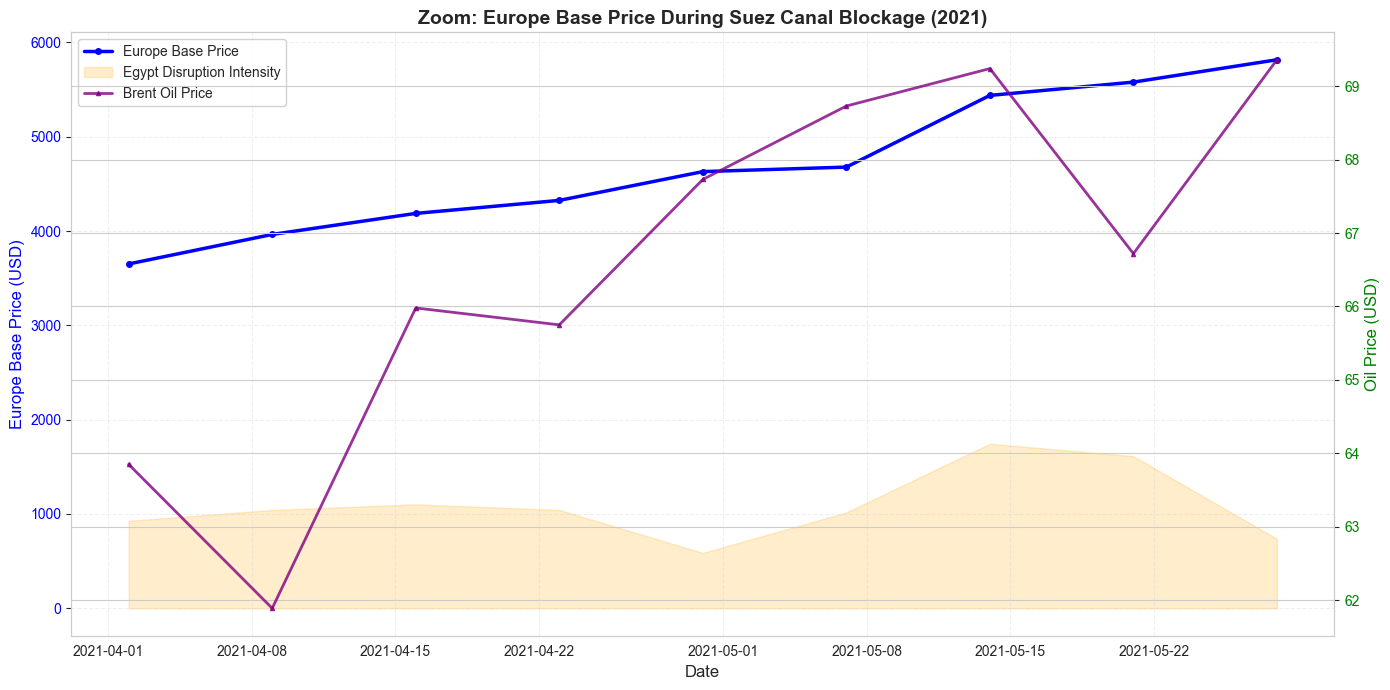

In [ ]:
import matplotlib.pyplot as plt

# Zoom in on Suez Canal blockage period
suez_start = '2021-01-01'
suez_end = '2021-06-01'
df_suez_zoom = df_model_data.loc[suez_start:suez_end].copy()

fig, ax1 = plt.subplots(figsize=(14, 7))

# Primary axis: Europe Base Price
color1 = 'blue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Europe Base Price (USD)', color=color1, fontsize=12)
ax1.plot(df_suez_zoom.index, df_suez_zoom['Europe_Base_Price'], 
         color=color1, linewidth=2.5, marker='o', markersize=4, 
         label='Europe Base Price', zorder=1)
ax1.tick_params(axis='y', labelcolor=color1)

# Secondary axis for oil prices
ax2 = ax1.twinx()
ax2.set_ylabel('Brent Oil Price (USD)', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

# Add Brent oil price
if 'Brent_Price' in df_suez_zoom.columns:
    ax2.plot(df_suez_zoom.index, df_suez_zoom['Brent_Price'], 
             color='purple', linewidth=2, marker='^', markersize=3,
             label='Brent Oil Price', alpha=0.8, zorder=2)

# Highlight Egypt disruption (Suez-related)
if 'egypt_disruption' in df_suez_zoom.columns:
    egypt_max = df_suez_zoom['egypt_disruption'].max()
    if egypt_max > 0:
        egypt_normalized = (df_suez_zoom['egypt_disruption'] / egypt_max) * df_suez_zoom['Europe_Base_Price'].max() * 0.3
        ax1.fill_between(df_suez_zoom.index, 0, egypt_normalized, 
                         color='orange', alpha=0.2, label='Egypt Disruption Intensity', zorder=0)

# Annotate the blockage period
suez_blockage_start = pd.Timestamp('2021-03-23')
suez_blockage_end = pd.Timestamp('2021-03-29')
if suez_blockage_start in df_suez_zoom.index:
    blockage_price = df_suez_zoom.loc[suez_blockage_start, 'Europe_Base_Price']
    ax1.annotate('Suez Canal Blockage\n(March 23-29, 2021)', 
                 xy=(suez_blockage_start, blockage_price),
                 xytext=(suez_blockage_start - pd.Timedelta(days=10), blockage_price + 500),
                 arrowprops=dict(arrowstyle='->', color='red', lw=2),
                 fontsize=10, fontweight='bold', color='red',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red'))

plt.title('Zoom: Europe Base Price During Suez Canal Blockage (2021)', 
          fontsize=14, fontweight='bold')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10, framealpha=0.9)

ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [ ]:
# ====================================================================
# FINAL SANITY CHECK - VERIFY FEATURES BEFORE SAVING
# ====================================================================
print("\n" + "="*80)
print("FINAL SANITY CHECK BEFORE SAVING CSV")
print("="*80)

# 1. Check if the dataframe exists and is not empty
if 'df_model_data' in locals() and not df_model_data.empty:
    print(f"✅ DataFrame 'df_model_data' exists and is not empty.")
    print(f"   - Shape: {df_model_data.shape}")
else:
    print(f"❌ CRITICAL ERROR: DataFrame 'df_model_data' is MISSING or EMPTY.")
    print("   This means an error occurred in a cell above, likely during merging or feature creation.")
    print("   Please scroll up and look for error messages in the output of previous cells.")

# 2. Check for the presence of new advanced features
if 'df_model_data' in locals() and not df_model_data.empty:
    new_feature_samples = [
        'Europe_Base_Price_roll_mean_4w_lag_1w',
        'Europe_Base_Price_pct_change_1w_lag_1w',
        'price_to_brent_ratio_lag_1w',
        'Europe_Base_Price_cv_4w_lag_1w'
    ]
    
    # Check all columns in the dataframe
    all_cols = df_model_data.columns.tolist()
    found_features = [f for f in new_feature_samples if f in all_cols]
    
    print("\n--- Checking for Advanced Features ---")
    if len(found_features) >= 3:
        print(f"✅ SUCCESS: Found {len(found_features)} out of {len(new_feature_samples)} sample advanced features.")
        print(f"   - Sample: {found_features}")
        print(f"   - Total columns: {len(all_cols)}")
        print("\n   This confirms the feature engineering code ran successfully.")
        print("   The 'model_data.csv' file should now be updated with these new columns.")

    else:
        print(f"❌ CRITICAL ERROR: Advanced features are MISSING from the final DataFrame.")
        print(f"   - Found only {len(found_features)} sample features.")
        print(f"   - This means the 'Advanced Feature Engineering' cell did not run correctly or was skipped.")
        print("   - Please ensure the cell with the title 'CREATING ADVANCED FEATURES' is present and has been executed without errors.")

print("="*80)



FINAL SANITY CHECK BEFORE SAVING CSV
✅ DataFrame 'df_model_data' exists and is not empty.
   - Shape: (209, 596)

--- Checking for Advanced Features ---
❌ CRITICAL ERROR: Advanced features are MISSING from the final DataFrame.
   - Found only 0 sample features.
   - This means the 'Advanced Feature Engineering' cell did not run correctly or was skipped.
   - Please ensure the cell with the title 'CREATING ADVANCED FEATURES' is present and has been executed without errors.
